# Data setup and cleaning

In [21]:
import pandas as pd
import numpy as np

In [4]:
# HELPER FUNCTIONS - DATA CLEANING

import re
HMTL_TAG = re.compile('<.*?>') 
WHITESPACE = re.compile(r'\s+')

def replace_html_tags(raw_html, replace_with = ''):
  clean_text = re.sub(HMTL_TAG, replace_with, str(raw_html))
  return clean_text

def replace_whitespace(raw_text, replace_with = ' '):
  clean_text = re.sub(WHITESPACE, replace_with, str(raw_text))
  return clean_text

def clean_text(raw_text):
  clean_text = replace_html_tags(raw_text)
  clean_text = replace_whitespace(clean_text)
  return clean_text

# Clean text for every row in a pandas dataframe column. Returns new dataframe with cleaned text.
def clean_text_batch(df: pd.DataFrame, col: int) -> pd.DataFrame:
  df.iloc[:, col] = df.iloc[:, col].apply(lambda x: clean_text(x))
  return df

In [54]:
# HELPER FUNCTIONS - DATA ANALYSIS / INTERPRETATION

LISTING_FIELDS = ['id','listing_url','scrape_id','last_scraped','source','name','description','neighborhood_overview','picture_url','host_id','host_url','host_name','host_since','host_location','host_about','host_response_time','host_response_rate','host_acceptance_rate','host_is_superhost','host_thumbnail_url','host_picture_url','host_neighbourhood','host_listings_count','host_total_listings_count','host_verifications','host_has_profile_pic','host_identity_verified','neighbourhood','neighbourhood_cleansed','neighbourhood_group_cleansed','latitude','longitude','property_type','room_type','accommodates','bathrooms','bathrooms_text','bedrooms','beds','amenities','price','minimum_nights','maximum_nights','minimum_minimum_nights','maximum_minimum_nights','minimum_maximum_nights','maximum_maximum_nights','minimum_nights_avg_ntm','maximum_nights_avg_ntm','calendar_updated','has_availability','availability_30','availability_60','availability_90','availability_365','calendar_last_scraped','number_of_reviews','number_of_reviews_ltm','number_of_reviews_l30d','first_review','last_review','review_scores_rating','review_scores_accuracy','review_scores_cleanliness','review_scores_checkin','review_scores_communication','review_scores_location','review_scores_value','license','instant_bookable','calculated_host_listings_count','calculated_host_listings_count_entire_homes','calculated_host_listings_count_private_rooms','calculated_host_listings_count_shared_rooms','reviews_per_month']
REVIEW_FIELDS = ['listing_id','id','date','reviewer_id','reviewer_name','comments']

# function to quickly return index of a given string in LISTING_FIELDS
def index_in_listings(field: str) -> int:
    return LISTING_FIELDS.index(field)

# function to quickly return index of a given string in REVIEW_FIELDS
def index_in_reviews(field: str) -> int:
    return REVIEW_FIELDS.index(field)

# function to map a string reading 't' or 'f' to a boolean
def as_bool(t_f: str) -> bool:
    if t_f == 't':
        return True
    elif t_f == 'f':
        return False
    else:
        raise ValueError('Invalid value for boolean: ' + t_f)

# function to normalise a numpy array to floats between 0 and 1
def normalise(arr: np.ndarray) -> np.ndarray:
    return arr / arr.sum()



In [6]:
# CLEAN LISTINGS TEXT AND SAVE TO NEW CSV
df_listings = pd.read_csv("../data/listings.csv")

# print(df_listings.applymap(lambda x: isinstance(x, str)).all(0))

# Names and indices of columns to clean
COLS_TO_CLEAN = {
    'description': 6,
    'neighborhood_overview': 7,
    'host_about': 14
}

for col in COLS_TO_CLEAN:
    df_listings = clean_text_batch(df_listings, COLS_TO_CLEAN[col])

# df_listings.to_csv('../data/listings_clean.csv', index=False)

In [52]:
# SELECT ONLY TARGET COLUMNS FROM LISTINGS -> SAVE TO NEW CSV

df_listings = pd.read_csv("../data/listings.csv")

# col names: review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value
LISTING_COLS_TO_RETAIN = {
    'id': index_in_listings('id'),
    'review_scores_rating': index_in_listings('review_scores_rating'),
    'review_scores_accuracy': index_in_listings('review_scores_accuracy'),
    'review_scores_cleanliness': index_in_listings('review_scores_cleanliness'),
    'review_scores_checkin': index_in_listings('review_scores_checkin'),
    'review_scores_communication': index_in_listings('review_scores_communication'),
    'review_scores_location': index_in_listings('review_scores_location'),
    'review_scores_value': index_in_listings('review_scores_value')
}

df_listings = df_listings.iloc[:, list(LISTING_COLS_TO_RETAIN.values())]
df_listings = df_listings.dropna()
df_listings = df_listings.sort_values(by=['id'])
df_listings.to_csv('../data/listings_targets.csv', index=False)

# NOTE: Some listings do not have some or all of the review scores. We will need to account for this when we train our model.

# print(df_listings.applymap(lambda x: isinstance(x, str)).all(0))


In [56]:
# CLEAN REVIEWS TEXT AND SELECT ONLY KEY COLUMNS -> SAVE TO NEW CSV

df_reviews = pd.read_csv("../data/reviews.csv")
df_reviews = clean_text_batch(df_reviews, 5)

REVIEW_COLS_TO_RETAIN = {
    'listing_id': index_in_reviews('listing_id'),
    'comments': index_in_reviews('comments')
}

df_reviews = df_reviews.iloc[:, list(REVIEW_COLS_TO_RETAIN.values())]

# Sort by listing_id, so reviews for a given listing are grouped together
df_reviews = df_reviews.sort_values(by=['listing_id'])
df_reviews.to_csv('../data/reviews_skeleton.csv', index=False)


In [24]:
comments = df_reviews.iloc[:, 5].values
print(comments.shape)
print(comments[0])

(243183,)
We enjoyed our stay very much. The room was comfortable, neat and clean. There were no problems at all and the host family was very helpful and caring. They helped us planning trips or recommended sights. The house is situated in a calm neighbourhood close the the Luas and different bus lines. There are no negative aspects to mention, it was a very satisfying stay. I would recommend it and stay there again whenever I am in Dublin. 


We are trying to predict the ratings of a listing based on reviews for that listing.

So in order to train the model, we need to group all reviews for a particular listing with the appropriate listing id.

# Features and Targets

In [57]:
df_listings = pd.read_csv("../data/listings.csv")

# col names: review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value
LISTING_COLS_TO_RETAIN = {
    'id': index_in_listings('id'),
    'review_scores_rating': index_in_listings('review_scores_rating'),
    'review_scores_accuracy': index_in_listings('review_scores_accuracy'),
    'review_scores_cleanliness': index_in_listings('review_scores_cleanliness'),
    'review_scores_checkin': index_in_listings('review_scores_checkin'),
    'review_scores_communication': index_in_listings('review_scores_communication'),
    'review_scores_location': index_in_listings('review_scores_location'),
    'review_scores_value': index_in_listings('review_scores_value')
}

targets = df_listings.iloc[:, list(LISTING_COLS_TO_RETAIN.values())]
targets = targets.dropna()
targets = targets.sort_values(by=['id'])

targ_ratings = targets.iloc[:, 1].values
targ_acc = targets.iloc[:, 2].values
targ_clean = targets.iloc[:, 3].values
targ_checkin = targets.iloc[:, 4].values
targ_comm = targets.iloc[:, 5].values
targ_loc = targets.iloc[:, 6].values
targ_value = targets.iloc[:, 7].values

# Save targets to csv
# targets.to_csv('../data/listings_targets_comp.csv', index=False)

In [58]:
print(targets.shape)

(6078, 8)


In [67]:
# Group review comments by listing_id
reviews = pd.read_csv("../data/reviews_skeleton.csv")
reviews = reviews.dropna()
reviews = reviews.sort_values(by=['listing_id'])
reviews_by_listing = reviews.groupby('listing_id').agg({'comments': '. '.join})
reviews_by_listing = reviews_by_listing.reset_index()
reviews_by_listing.to_csv('../data/reviews_by_listing.csv', index=False)

# Tokenise and stem reviews
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

stemmer = PorterStemmer()

# Function to map each string of comments to stems
def stem_review(review):
    tokens = word_tokenize(review)
    stems = [stemmer.stem(token) for token in tokens]
    return ' '.join(stems)

reviews_by_listing['stems'] = reviews_by_listing['comments'].apply(stem_review)

stems_by_listing = reviews_by_listing[['listing_id', 'stems']]

# for index, row in reviews_by_listing.iterrows():
#     listing_id = row['listing_id']
#     comments = row['comments']
#     tokens = word_tokenize(comments)
#     stems = [stemmer.stem(token) for token in tokens]
#     ' '.join(stems)
#     stems_by_listing.append([listing_id, stems])

# stems_by_listing = pd.DataFrame(stems_by_listing, columns=['listing_id', 'stems'])

# Save stems to csv
stems_by_listing.to_csv('../data/stems_by_listing.csv', index=False)



In [68]:
# SELECT ONLY LISTINGS WITH BOTH REVIEWS AND TARGETS
reviews = pd.read_csv("../data/stems_by_listing.csv")
targets = pd.read_csv("../data/listings_targets_comp.csv")

# Sort both by listing_id
reviews = reviews.sort_values(by=['listing_id'])
targets = targets.sort_values(by=['id'])

# Drop rows where listing_id is not included in both
reviews = reviews[reviews['listing_id'].isin(targets['id'])]
targets = targets[targets['id'].isin(reviews['listing_id'])]


In [69]:
# Should have same number of rows (but different number of columns)
print(reviews.shape)
print(targets.shape)

(6078, 2)
(6078, 8)


In [71]:
stemmed_comments = reviews['stems'].values

import nltk
nltk.download('punkt')
nltk.download('stopwords')

from sklearn.feature_extraction.text import TfidfVectorizer

# df_max - exclude words which appear in too many documents
# df_min - exclude words which appear in too few documents
# Use cross validation to determine best values for these parameters.
# HAVE TO USE MIN_DF, otherwise feature vectors are:
# a) too large for my computer to handle.
# b) too full of zeros to be useful.
# vectorizer = TfidfVectorizer(stop_words='english', max_df=0.2, min_df=0.001) # 93,193 features
vectorizer = TfidfVectorizer(stop_words='english') # 79,179 features for 6,078 listings

# A single doc will be a list of sentences, in this case a single review.
# Each sentence will be a list of words, or in this case tokens, which have been stemmed.
X = vectorizer.fit_transform(stemmed_comments)
print(len(vectorizer.get_feature_names_out()))
print(X.shape)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\james\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\james\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


79179
(6078, 79179)


In [91]:
Y = targets.iloc[:, 1:].values
print(Y.shape)

# Split into different categories
Y_rating = Y[:, 0]
Y_acc = Y[:, 1]
Y_clean = Y[:, 2]
Y_checkin = Y[:, 3]
Y_comm = Y[:, 4]
Y_loc = Y[:, 5]
Y_value = Y[:, 6]


(6078, 7)


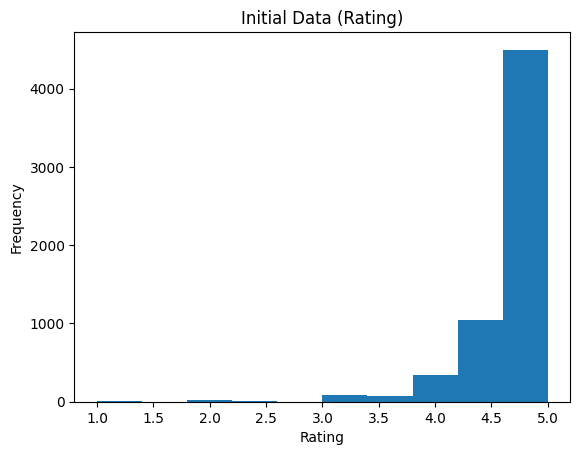

In [463]:
counts, bins = np.histogram(Y_rating)
plt.stairs(counts, bins, fill=True)

plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.title('Initial Data (Rating)')
plt.show()

In [89]:
print(X.shape)
print(X.shape[0])

(6078, 79179)
6078


Other features

In [116]:
listings = pd.read_csv("../data/listings_clean.csv")

# Pull out interesting features
FEATURES_OF_INTEREST = {
    'id': index_in_listings('id'),
    'host_is_superhost': index_in_listings('host_is_superhost'),
    'host_total_listings_count': index_in_listings('host_total_listings_count'),
    'accommodates': index_in_listings('accommodates'),
    'number_of_reviews': index_in_listings('number_of_reviews')
}

# Create a new dataframe with only the features of interest, and save to new csv
listings_extra_features = listings.iloc[:, list(FEATURES_OF_INTEREST.values())]
listings_extra_features.to_csv('../data/listings_extra_features.csv', index=False)



# Text Feature Extraction


min_df = 0.2
 - max_df = 0.8
 - max_df = 0.9
 - max_df = 1.0
min_df = 0.4
 - max_df = 0.8
 - max_df = 0.9
 - max_df = 1.0
min_df = 0.5
 - max_df = 0.8
 - max_df = 0.9
 - max_df = 1.0
min_df = 0.6
 - max_df = 0.8
 - max_df = 0.9
 - max_df = 1.0


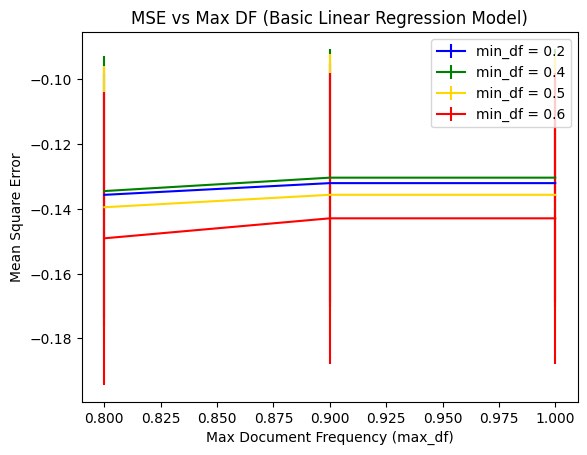

In [115]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer

colors = ['blue', 'green', 'gold', 'red', 'pink']

# df_min - exclude words which appear in too few documents
min_df_range = [0.2, 0.4, 0.5, 0.6]
# df_max - exclude words which appear in too many documents
max_df_range = [0.8, 0.9, 1.0]

for min_df_index, min_df in enumerate(min_df_range):
    print(f'min_df = {min_df}')

    mean_score=[]
    std_score=[]

    for max_df in max_df_range:
        print(f' - max_df = {max_df}')

        vectorizer = TfidfVectorizer(stop_words='english', min_df=min_df, max_df=max_df) # 79,179 features for 6,078 listings
        X = vectorizer.fit_transform(stemmed_comments)

        model = LinearRegression()
        kf = KFold(n_splits=5)

        scores = cross_val_score(model, X, Y_rating, cv=kf, scoring='neg_mean_squared_error')
        mean_score.append(np.array(scores).mean())
        std_score.append(np.array(scores).std())

    plt.errorbar(max_df_range,mean_score,yerr=std_score,color=colors[min_df_index],label=f'min_df = {min_df}')

plt.title('MSE vs Max DF (Basic Linear Regression Model)')
plt.xlabel('Max Document Frequency (max_df)')
plt.ylabel('Mean Square Error')
plt.legend()
plt.show()

In [113]:
# Set min_df and max_df to the values that gave the best results (lowest MSE)
MIN_DF = 0.4
MAX_DF = 0.9

vectorizer = TfidfVectorizer(stop_words='english', min_df=MIN_DF, max_df=MAX_DF) # 79,179 features for 6,078 listings
X = vectorizer.fit_transform(stemmed_comments)


In [188]:
def normalise_feat(feat):
    """Normalise a feature so that it has mean 0 and standard deviation 1."""
    return np.log(feat) / (1 + np.log(feat))

In [114]:
print(X.shape)

(6078, 101)


# Modelling
Now we have our text features and our targets ready to go, we can begin on our model.

C = 0.1
C = 0.15
C = 0.2
C = 0.25
C = 0.3


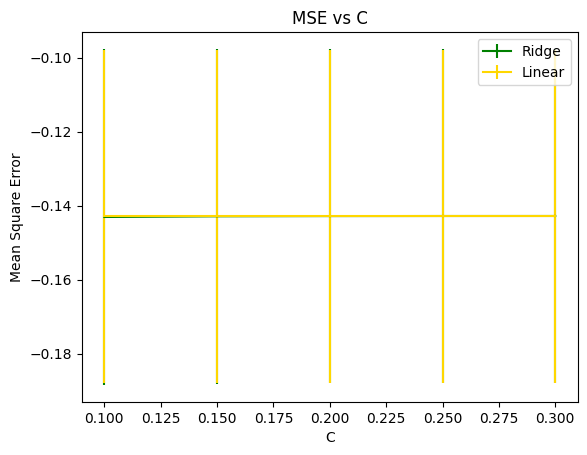

In [157]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.feature_extraction.text import TfidfVectorizer

colors = ['blue', 'green', 'gold', 'red', 'pink']
c_range = [0.1, 0.15, 0.2, 0.25, 0.3]
# c_range = [2000, 4000, 6000, 8000, 10000]

m_linear = LinearRegression()

me_lasso = []
me_ridge = []
me_linear = []

se_lasso = []
se_ridge = []
se_linear = []

for c in c_range:
    print(f'C = {c}')
    
    m_lasso = Lasso(alpha=1/c)
    m_ridge = Ridge(alpha=1/c)

    kf = KFold(n_splits=5)

    errors_lasso = cross_val_score(m_lasso, X, Y_rating, cv=kf, scoring='neg_mean_squared_error')
    errors_ridge = cross_val_score(m_ridge, X, Y_rating, cv=kf, scoring='neg_mean_squared_error')
    errors_linear = cross_val_score(model, X, Y_rating, cv=kf, scoring='neg_mean_squared_error')

    me_lasso.append(np.array(errors_lasso).mean())
    me_ridge.append(np.array(errors_ridge).mean())
    me_linear.append(np.array(errors_linear).mean())

    se_lasso.append(np.array(errors_lasso).std())
    se_ridge.append(np.array(errors_ridge).std())
    se_linear.append(np.array(errors_linear).std())

plt.errorbar(c_range,me_lasso,yerr=se_lasso,color=colors[0],label=f'Lasso')
plt.errorbar(c_range,me_ridge,yerr=se_ridge,color=colors[1],label=f'Ridge')
plt.errorbar(c_range,me_linear,yerr=se_linear,color=colors[2],label=f'Linear')

plt.title('MSE vs C')
plt.xlabel('C')
plt.ylabel('Mean Square Error')
plt.legend()
plt.show()

Standard Linear Regression (no regularization) works best. (Don't even really need to include this plot, since don't need cross-validation to select any C with no penalty)

In [275]:
def gaussian_kernel100(distances):
    weights = np.exp(-100*(distances**2))
    return weights/np.sum(weights)

def gaussian_kernel1000(distances):
    weights = np.exp(-1000*(distances**2))
    return weights/np.sum(weights)

def gaussian_kernel5000(distances):
    weights = np.exp(-5000*(distances**2))
    return weights/np.sum(weights)


k = 1
k = 2
k = 3
k = 4
k = 5
k = 6
k = 7
k = 8
k = 9
k = 10


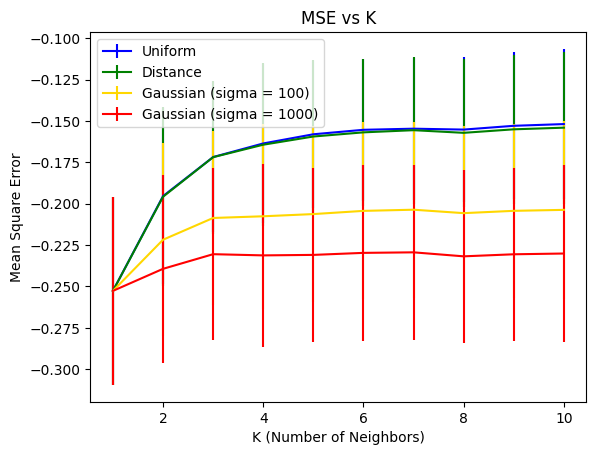

In [141]:
# CROSS-VALIDATION TO GET K FOR KNN MODEL

from sklearn.neighbors import KNeighborsRegressor

k_range = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

# Want a model with uniform weights, a model with distance weights, and a model for each of the three kernels
# And perform cross-validation on each of these models to get the best k

me_unif = []
me_dist = []
me_gaus100 = []
me_gaus1000 = []
# me_gaus5000 = []

se_unif = []
se_dist = []
se_gaus100 = []
se_gaus1000 = []
# se_gaus5000 = []

for k in k_range:
    print(f'k = {k}')
    
    # Model with uniform weights, a model with distance weights, and a model for each of the three kernels
    m_unif = KNeighborsRegressor(n_neighbors=k, weights='uniform')
    m_dist = KNeighborsRegressor(n_neighbors=k, weights='distance')
    m_gaus100 = KNeighborsRegressor(n_neighbors=k, weights=gaussian_kernel100)
    m_gaus1000 = KNeighborsRegressor(n_neighbors=k, weights=gaussian_kernel1000)
    # m_gaus5000 = KNeighborsRegressor(n_neighbors=k, weights=gaussian_kernel5000)

    kf = KFold(n_splits=5)

    errors_unif = cross_val_score(m_unif, X, Y_rating, cv=kf, scoring='neg_mean_squared_error')
    errors_dist = cross_val_score(m_dist, X, Y_rating, cv=kf, scoring='neg_mean_squared_error')
    errors_gaus100 = cross_val_score(m_gaus100, X, Y_rating, cv=kf, scoring='neg_mean_squared_error')
    errors_gaus1000 = cross_val_score(m_gaus1000, X, Y_rating, cv=kf, scoring='neg_mean_squared_error')
    # errors_gaus5000 = cross_val_score(m_gaus5000, X, Y_rating, cv=kf, scoring='neg_mean_squared_error')

    me_unif.append(np.array(errors_unif).mean())
    me_dist.append(np.array(errors_dist).mean())
    me_gaus100.append(np.array(errors_gaus100).mean())
    me_gaus1000.append(np.array(errors_gaus1000).mean())
    # me_gaus5000.append(np.array(errors_gaus5000).mean())

    se_unif.append(np.array(errors_unif).std())
    se_dist.append(np.array(errors_dist).std())
    se_gaus100.append(np.array(errors_gaus100).std())
    se_gaus1000.append(np.array(errors_gaus1000).std())
    # se_gaus5000.append(np.array(errors_gaus5000).std())

plt.errorbar(k_range,me_unif,yerr=se_unif,color=colors[0],label=f'Uniform')
plt.errorbar(k_range,me_dist,yerr=se_dist,color=colors[1],label=f'Distance')
plt.errorbar(k_range,me_gaus100,yerr=se_gaus100,color=colors[2],label=f'Gaussian (sigma = 100)')
plt.errorbar(k_range,me_gaus1000,yerr=se_gaus1000,color=colors[3],label=f'Gaussian (sigma = 1000)')
# plt.errorbar(k_range,me_gaus5000,yerr=se_gaus5000,color=colors[4],label=f'Gaussian (sigma = 5000)')

plt.title('MSE vs K')
plt.xlabel('K (Number of Neighbors)')
plt.ylabel('Mean Square Error')
plt.legend()
plt.show()


k = 6 neighbours w/ uniform weighting seems best

In [173]:
print(X[0])

  (0, 14)	0.06142421025102774
  (0, 6)	0.06831220557453328
  (0, 26)	0.06530440040750915
  (0, 0)	0.14158323005274073
  (0, 9)	0.1755342826810126
  (0, 7)	0.0963957522795151
  (0, 17)	0.19972038496654274
  (0, 16)	0.06938175563667849
  (0, 13)	0.23814942468919867
  (0, 8)	0.08481125490189349
  (0, 18)	0.13811275176438467
  (0, 22)	0.10053462460183046
  (0, 23)	0.0966463873583065
  (0, 4)	0.020715871731662838
  (0, 12)	0.07006233591516377
  (0, 15)	0.13558551169626268
  (0, 5)	0.2594678938936784
  (0, 2)	0.05198102592794461
  (0, 19)	0.15793580800753423
  (0, 10)	0.23798401519791101
  (0, 11)	0.1713783120193516
  (0, 1)	0.10906540106976151
  (0, 3)	0.1360730498157233
  (0, 25)	0.49171972300621425
  (0, 20)	0.188708420468916
  (0, 24)	0.35233609865276494
  (0, 21)	0.3786343949273005


MSE for Linear Regression: 0.12419831253896425
MSE for KNN: 0.1322929299159357
MSE for Mean: 0.1621077187664973
MSE for Constant: 0.6310181743421053


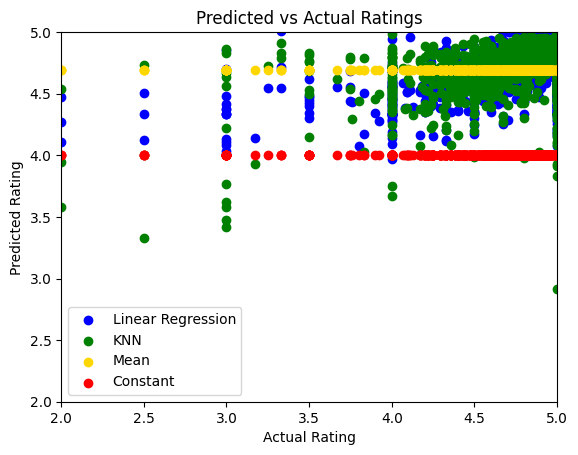

In [174]:
# COMPARE PERFORMANCE OF LINEAR AND KNN MODELS, ALONG WITH BASELINE PREDICTORS

# First get training and test data indices
from sklearn.model_selection import train_test_split
indices = np.arange(X.shape[0])
train, test = train_test_split(indices, test_size=0.2, random_state=0)


from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor
from sklearn.metrics import roc_curve, auc

# Linear Regression
m_linear = LinearRegression()
m_linear.fit(X.toarray()[train], Y_rating[train])

# KNN
m_knn = KNeighborsRegressor(n_neighbors=6, weights='uniform')
m_knn.fit(X.toarray()[train], Y_rating[train])

# Baseline predictors (mean value and constant 4)
m_mean = DummyRegressor(strategy='mean')
m_mean.fit(X.toarray()[train], Y_rating[train])
m_const = DummyRegressor(strategy='constant', constant=4)
m_const.fit(X.toarray()[train], Y_rating[train])

# Get predictions for all models
pred_linear = m_linear.predict(X.toarray()[test])
pred_knn = m_knn.predict(X.toarray()[test])
pred_mean = m_mean.predict(X.toarray()[test])
pred_const = m_const.predict(X.toarray()[test])

# Calculate MSE for all models
from sklearn.metrics import mean_squared_error
mse_linear = mean_squared_error(Y_rating[test], pred_linear)
mse_knn = mean_squared_error(Y_rating[test], pred_knn)
mse_mean = mean_squared_error(Y_rating[test], pred_mean)
mse_const = mean_squared_error(Y_rating[test], pred_const)

print(f'MSE for Linear Regression: {mse_linear}')
print(f'MSE for KNN: {mse_knn}')
print(f'MSE for Mean: {mse_mean}')
print(f'MSE for Constant: {mse_const}')

# Visualise performance of all models
plt.scatter(Y_rating[test], pred_linear, color=colors[0], label='Linear Regression')
plt.scatter(Y_rating[test], pred_knn, color=colors[1], label='KNN')
plt.scatter(Y_rating[test], pred_mean, color=colors[2], label='Mean')
plt.scatter(Y_rating[test], pred_const, color=colors[3], label='Constant')

plt.title('Predicted vs Actual Ratings')
plt.xlabel('Actual Rating')
plt.xlim(2,5)
plt.ylabel('Predicted Rating')
plt.ylim(2,5)
plt.legend()
plt.show()



Not good :\

# Adding extra features
Trying again with extra features

In [257]:
# Merge reviews with listings_extra_features where listing_id matches, and only keep one id column
all_features = pd.merge(listings_extra_features, reviews, left_on='id', right_on='listing_id', how='inner')
all_features = all_features.drop(columns=['listing_id'])

# Convert host_is_superhost to 0/1
all_features['host_is_superhost'] = all_features['host_is_superhost'].apply(lambda x: 1 if x == 't' else 0)

# Save to csv
all_features.to_csv('../data/all_features.csv', index=False)

all_features.dropna(inplace=True)


In [258]:
all_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6078 entries, 0 to 6077
Data columns (total 6 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   id                         6078 non-null   int64 
 1   host_is_superhost          6078 non-null   int64 
 2   host_total_listings_count  6078 non-null   int64 
 3   accommodates               6078 non-null   int64 
 4   number_of_reviews          6078 non-null   int64 
 5   stems                      6078 non-null   object
dtypes: int64(5), object(1)
memory usage: 332.4+ KB


Defining ColumnTransformer (CT)

In [265]:
# Create pipeline to use TF-IDF vectorizer on stems and passthrough other features
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer

# Set min_df and max_df to the values that gave the best results (lowest MSE)
MIN_DF = 0.4
MAX_DF = 0.9

CT = make_column_transformer(
    (StandardScaler(), ['host_total_listings_count', 'accommodates', 'number_of_reviews']),
    (TfidfVectorizer(stop_words='english', min_df=MIN_DF, max_df=MAX_DF), 'stems'),
    ('drop', 'id'),
    remainder='passthrough'
)

# pipeline = Pipeline([
#     ('transformer',  ct)
# ])

new_X = CT.fit_transform(all_features)

# print(new_X.shape)
# print(ct.get_feature_names())

# pipeline = pipe.fit_transform(all_features)



In [260]:
print(CT.get_feature_names_out())


['standardscaler__host_total_listings_count'
 'standardscaler__accommodates' 'standardscaler__number_of_reviews'
 'tfidfvectorizer__10' 'tfidfvectorizer__access'
 'tfidfvectorizer__accommod' 'tfidfvectorizer__airbnb'
 'tfidfvectorizer__amaz' 'tfidfvectorizer__ani' 'tfidfvectorizer__apart'
 'tfidfvectorizer__area' 'tfidfvectorizer__arriv' 'tfidfvectorizer__away'
 'tfidfvectorizer__bathroom' 'tfidfvectorizer__beauti'
 'tfidfvectorizer__bed' 'tfidfvectorizer__befor' 'tfidfvectorizer__best'
 'tfidfvectorizer__bu' 'tfidfvectorizer__center' 'tfidfvectorizer__centr'
 'tfidfvectorizer__check' 'tfidfvectorizer__citi' 'tfidfvectorizer__clean'
 'tfidfvectorizer__close' 'tfidfvectorizer__come'
 'tfidfvectorizer__comfort' 'tfidfvectorizer__commun'
 'tfidfvectorizer__conveni' 'tfidfvectorizer__day'
 'tfidfvectorizer__definit' 'tfidfvectorizer__did'
 'tfidfvectorizer__distanc' 'tfidfvectorizer__dublin'
 'tfidfvectorizer__easi' 'tfidfvectorizer__en' 'tfidfvectorizer__enjoy'
 'tfidfvectorizer__et' 'tfi

Cross-validation for C

C = 0.1
C = 0.2
C = 0.3
C = 0.4
C = 0.6


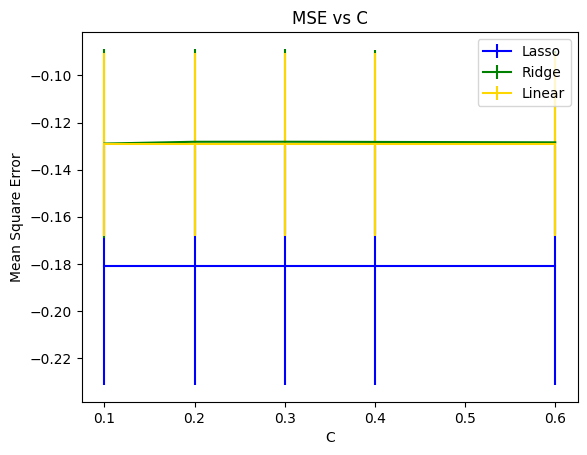

In [282]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline

colors = ['blue', 'green', 'gold', 'red', 'pink']
c_range = [0.1, 0.2, 0.3, 0.4, 0.6]
# c_range = [2000, 4000, 6000, 8000, 10000]

m_linear = LinearRegression()

me_lasso = []
me_ridge = []
me_linear = []

se_lasso = []
se_ridge = []
se_linear = []

for c in c_range:
    print(f'C = {c}')
    
    m_lasso = Lasso(alpha=1/c)
    m_ridge = Ridge(alpha=1/c)

    kf = KFold(n_splits=5)

    errors_lasso = cross_val_score(m_lasso, new_X, Y_rating, cv=kf, scoring='neg_mean_squared_error')
    errors_ridge = cross_val_score(m_ridge, new_X, Y_rating, cv=kf, scoring='neg_mean_squared_error')
    errors_linear = cross_val_score(model, new_X, Y_rating, cv=kf, scoring='neg_mean_squared_error')

    me_lasso.append(np.array(errors_lasso).mean())
    me_ridge.append(np.array(errors_ridge).mean())
    me_linear.append(np.array(errors_linear).mean())

    se_lasso.append(np.array(errors_lasso).std())
    se_ridge.append(np.array(errors_ridge).std())
    se_linear.append(np.array(errors_linear).std())

plt.errorbar(c_range,me_lasso,yerr=se_lasso,color=colors[0],label=f'Lasso')
plt.errorbar(c_range,me_ridge,yerr=se_ridge,color=colors[1],label=f'Ridge')
plt.errorbar(c_range,me_linear,yerr=se_linear,color=colors[2],label=f'Linear')

plt.title('MSE vs C')
plt.xlabel('C')
plt.ylabel('Mean Square Error')
plt.legend()
plt.show()

Not much difference, but Ridge slightly better. No difference with C value above 0.2

In [277]:
def gaussian_kernel10(distances):
    weights = np.exp(-10*(distances**2))
    return weights/np.sum(weights)
    
def gaussian_kernel50(distances):
    weights = np.exp(-50*(distances**2))
    return weights/np.sum(weights)

Cross-validation for K

k = 1
k = 2
k = 3
k = 4
k = 5
k = 6
k = 7
k = 8
k = 9
k = 10


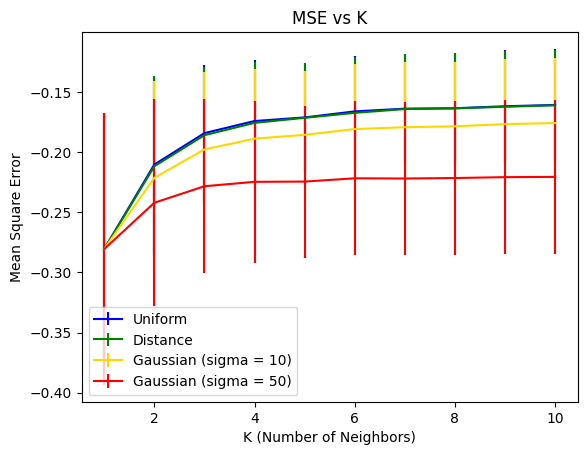

In [281]:
# CROSS-VALIDATION TO GET K FOR KNN MODEL

from sklearn.neighbors import KNeighborsRegressor

k_range = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

# Want a model with uniform weights, a model with distance weights, and a model for each of the three kernels
# And perform cross-validation on each of these models to get the best k

me_unif = []
me_dist = []
me_gaus10 = []
me_gaus50 = []

se_unif = []
se_dist = []
se_gaus10 = []
se_gaus50 = []

for k in k_range:
    print(f'k = {k}')
    
    # Model with uniform weights, a model with distance weights, and a model for each of the three kernels
    m_unif = KNeighborsRegressor(n_neighbors=k, weights='uniform')
    m_dist = KNeighborsRegressor(n_neighbors=k, weights='distance')
    m_gaus10 = KNeighborsRegressor(n_neighbors=k, weights=gaussian_kernel10)
    m_gaus50 = KNeighborsRegressor(n_neighbors=k, weights=gaussian_kernel50)

    kf = KFold(n_splits=5)

    errors_unif = cross_val_score(m_unif, new_X, Y_rating, cv=kf, scoring='neg_mean_squared_error')
    errors_dist = cross_val_score(m_dist, new_X, Y_rating, cv=kf, scoring='neg_mean_squared_error')
    errors_gaus10 = cross_val_score(m_gaus10, new_X, Y_rating, cv=kf, scoring='neg_mean_squared_error')
    errors_gaus50 = cross_val_score(m_gaus50, new_X, Y_rating, cv=kf, scoring='neg_mean_squared_error')

    me_unif.append(np.array(errors_unif).mean())
    me_dist.append(np.array(errors_dist).mean())
    me_gaus10.append(np.array(errors_gaus10).mean())
    me_gaus50.append(np.array(errors_gaus50).mean())

    se_unif.append(np.array(errors_unif).std())
    se_dist.append(np.array(errors_dist).std())
    se_gaus10.append(np.array(errors_gaus10).std())
    se_gaus50.append(np.array(errors_gaus50).std())

plt.errorbar(k_range,me_unif,yerr=se_unif,color=colors[0],label=f'Uniform')
plt.errorbar(k_range,me_dist,yerr=se_dist,color=colors[1],label=f'Distance')
plt.errorbar(k_range,me_gaus10,yerr=se_gaus10,color=colors[2],label=f'Gaussian (sigma = 10)')
plt.errorbar(k_range,me_gaus50,yerr=se_gaus50,color=colors[3],label=f'Gaussian (sigma = 50)')

plt.title('MSE vs K')
plt.xlabel('K (Number of Neighbors)')
plt.ylabel('Mean Square Error')
plt.legend()
plt.show()


Still k = 6 w/ uniform weighting

MSE for Ridge Regression: 0.1074653698953815
MSE for KNN: 0.14809508177997074
MSE for Mean: 0.1621077187664973
MSE for Constant: 0.1961579769736842


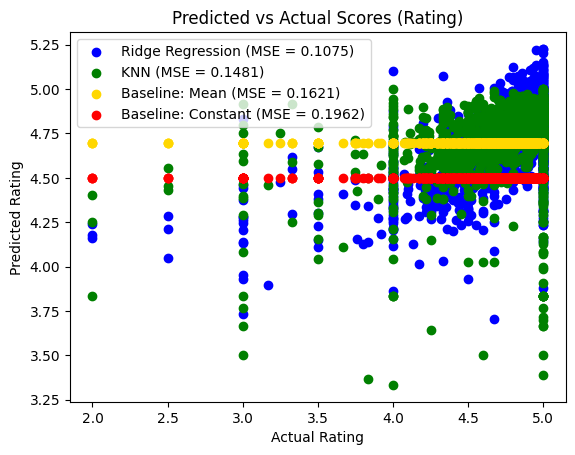

In [320]:
# COMPARE PERFORMANCE OF LINEAR AND KNN MODELS, ALONG WITH BASELINE PREDICTORS (Y_rating)

# First get training and test data indices
from sklearn.model_selection import train_test_split
indices = np.arange(new_X.shape[0])
train, test = train_test_split(indices, test_size=0.2, random_state=0)


from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor
from sklearn.metrics import roc_curve, auc

# Linear Regression
# m_linear = LinearRegression()
# m_linear.fit(new_X[train], Y_rating[train])

# Ridge Regression
optimal_c = 0.2
m_ridge = Ridge(alpha=1/optimal_c)
m_ridge.fit(new_X[train], Y_rating[train])

# KNN
m_knn = KNeighborsRegressor(n_neighbors=6, weights='uniform')
m_knn.fit(new_X[train], Y_rating[train])

# Baseline predictors (mean value and constant 4)
m_mean = DummyRegressor(strategy='mean')
m_mean.fit(new_X[train], Y_rating[train])
m_const = DummyRegressor(strategy='constant', constant=4.5)
m_const.fit(new_X[train], Y_rating[train])

# Get predictions for all models
# pred_linear = m_linear.predict(new_X[test])
pred_ridge = m_ridge.predict(new_X[test])
pred_knn = m_knn.predict(new_X[test])
pred_mean = m_mean.predict(new_X[test])
pred_const = m_const.predict(new_X[test])

# Calculate MSE for all models
from sklearn.metrics import mean_squared_error
# mse_linear = mean_squared_error(Y_rating[test], pred_linear)
mse_ridge = mean_squared_error(Y_rating[test], pred_ridge)
mse_knn = mean_squared_error(Y_rating[test], pred_knn)
mse_mean = mean_squared_error(Y_rating[test], pred_mean)
mse_const = mean_squared_error(Y_rating[test], pred_const)

# print(f'MSE for Linear Regression: {mse_linear}')
print(f'MSE for Ridge Regression: {mse_ridge}')
print(f'MSE for KNN: {mse_knn}')
print(f'MSE for Mean: {mse_mean}')
print(f'MSE for Constant: {mse_const}')

# Visualise performance of all models
# plt.scatter(Y_rating[test], pred_linear, color=colors[0], label='Linear Regression')
plt.scatter(Y_rating[test], pred_ridge, color=colors[0], label=f'Ridge Regression (MSE = {mse_ridge:.4f})')
plt.scatter(Y_rating[test], pred_knn, color=colors[1], label=f'KNN (MSE = {mse_knn:.4f})')
plt.scatter(Y_rating[test], pred_mean, color=colors[2], label=f'Baseline: Mean (MSE = {mse_mean:.4f})')
plt.scatter(Y_rating[test], pred_const, color=colors[3], label=f'Baseline: Constant (MSE = {mse_const:.4f})')

plt.title('Predicted vs Actual Scores (Rating)')
plt.xlabel('Actual Rating')
# plt.xlim(2,5)
plt.ylabel('Predicted Rating')
# plt.ylim(2,5)
plt.legend()
plt.show()



In [418]:
# Print coefficients for extra features
# host_is_superhost
print(f'host_is_superhost: {m_linear.coef_[np.where(CT.get_feature_names_out() == "remainder__host_is_superhost")]}')
# host_total_listings_count
print(f'host_total_listings_count: {m_linear.coef_[np.where(CT.get_feature_names_out() == "standardscaler__host_total_listings_count")]}')
# accommodates
print(f'accommodates: {m_linear.coef_[np.where(CT.get_feature_names_out() == "standardscaler__accommodates")]}')
# number_of_reviews
print(f'number_of_reviews: {m_linear.coef_[np.where(CT.get_feature_names_out() == "standardscaler__number_of_reviews")]}')

# Find the most important features
# Get the indices of the top 5 features
top5 = np.argsort(m_linear.coef_)[-5:]
# Get the names of the top 5 features
top5_names = CT.get_feature_names_out()[top5]
# Get the values of the top 5 features
top5_values = m_linear.coef_[top5]
# Print the top 5 features
for i in range(len(top5)):
    print(f'{top5_names[i]}: {top5_values[i]}')


AttributeError: 'LinearRegression' object has no attribute 'coef_'

In [425]:
def print_key_coefs(coefs, transformer):
    # Print coefficients for extra features
    print('\nCoefs - Features of interest:\n----------------')

    # host_is_superhost
    print(f'host_is_superhost: {coefs[np.where(transformer.get_feature_names_out() == "remainder__host_is_superhost")]}')
    # host_total_listings_count
    print(f'host_total_listings_count: {coefs[np.where(transformer.get_feature_names_out() == "standardscaler__host_total_listings_count")]}')
    # accommodates
    print(f'accommodates: {coefs[np.where(transformer.get_feature_names_out() == "standardscaler__accommodates")]}')
    # number_of_reviews
    print(f'number_of_reviews: {coefs[np.where(transformer.get_feature_names_out() == "standardscaler__number_of_reviews")]}')


    # Find the 5 most increasing features
    print('\nCoefs - Top 5 increasing features:\n----------------')

    # Get the indices of the top 5 features
    top5 = np.argsort(coefs)[-5:]
    # Get the names of the top 5 features
    top5_names = transformer.get_feature_names_out()[top5]
    # Get the values of the top 5 features
    top5_values = coefs[top5]
    # Print the top 5 features
    for i in range(len(top5)):
        print(f'{top5_names[i]}: {top5_values[i]}')


    # Find the 5 most decreasing features
    print('\nCoefs - Top 5 decreasing features:\n----------------')

    # Get the indices of the top 5 features
    top5 = np.argsort(coefs)[:5]
    # Get the names of the top 5 features
    top5_names = transformer.get_feature_names_out()[top5]
    # Get the values of the top 5 features
    top5_values = coefs[top5]
    # Print the top 5 features
    for i in range(len(top5)):
        print(f'{top5_names[i]}: {top5_values[i]}')


This is actually interesting. Not bad!

Accuracy

MSE for Ridge Regression: 0.12590260965944686
MSE for KNN: 0.15195025584795321
MSE for Mean: 0.14900415102649778
MSE for Constant: 0.2210547697368421


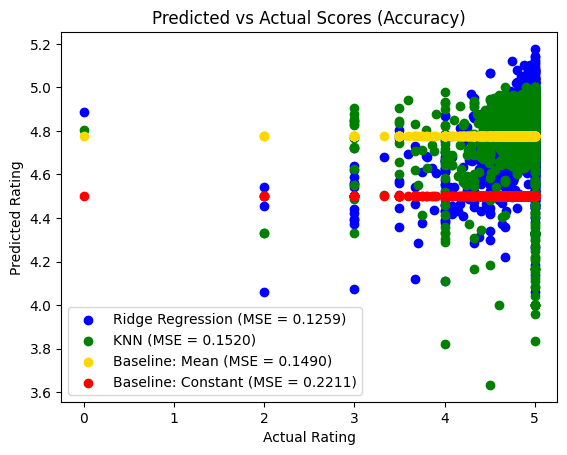

In [319]:
# COMPARE PERFORMANCE OF LINEAR AND KNN MODELS, ALONG WITH BASELINE PREDICTORS (Y_acc)

# Ridge Regression
optimal_c = 0.2
m_ridge = Ridge(alpha=1/optimal_c)
m_ridge.fit(new_X[train], Y_acc[train])

# KNN
m_knn = KNeighborsRegressor(n_neighbors=6, weights='uniform')
m_knn.fit(new_X[train], Y_acc[train])

# Baseline predictors (mean value and constant 4)
m_mean = DummyRegressor(strategy='mean')
m_mean.fit(new_X[train], Y_acc[train])
m_const = DummyRegressor(strategy='constant', constant=4.5)
m_const.fit(new_X[train], Y_acc[train])

# Get predictions for all models
# pred_linear = m_linear.predict(new_X[test])
pred_ridge = m_ridge.predict(new_X[test])
pred_knn = m_knn.predict(new_X[test])
pred_mean = m_mean.predict(new_X[test])
pred_const = m_const.predict(new_X[test])

# Calculate MSE for all models
from sklearn.metrics import mean_squared_error
# mse_linear = mean_squared_error(Y_acc[test], pred_linear)
mse_ridge = mean_squared_error(Y_acc[test], pred_ridge)
mse_knn = mean_squared_error(Y_acc[test], pred_knn)
mse_mean = mean_squared_error(Y_acc[test], pred_mean)
mse_const = mean_squared_error(Y_acc[test], pred_const)

# print(f'MSE for Linear Regression: {mse_linear}')
print(f'MSE for Ridge Regression: {mse_ridge}')
print(f'MSE for KNN: {mse_knn}')
print(f'MSE for Mean: {mse_mean}')
print(f'MSE for Constant: {mse_const}')

# Visualise performance of all models
# plt.scatter(Y_acc[test], pred_linear, color=colors[0], label='Linear Regression')
plt.scatter(Y_acc[test], pred_ridge, color=colors[0], label=f'Ridge Regression (MSE = {mse_ridge:.4f})')
plt.scatter(Y_acc[test], pred_knn, color=colors[1], label=f'KNN (MSE = {mse_knn:.4f})')
plt.scatter(Y_acc[test], pred_mean, color=colors[2], label=f'Baseline: Mean (MSE = {mse_mean:.4f})')
plt.scatter(Y_acc[test], pred_const, color=colors[3], label=f'Baseline: Constant (MSE = {mse_const:.4f})')

plt.title('Predicted vs Actual Scores (Accuracy)')
plt.xlabel('Actual Rating')
# plt.xlim(2,5)
plt.ylabel('Predicted Rating')
# plt.ylim(2,5)
plt.legend()
plt.show()



MSE for Ridge Regression: 0.2028041983361959
MSE for KNN: 0.25693259548611114
MSE for Mean: 0.2618890442342917
MSE for Constant: 0.2827449013157895


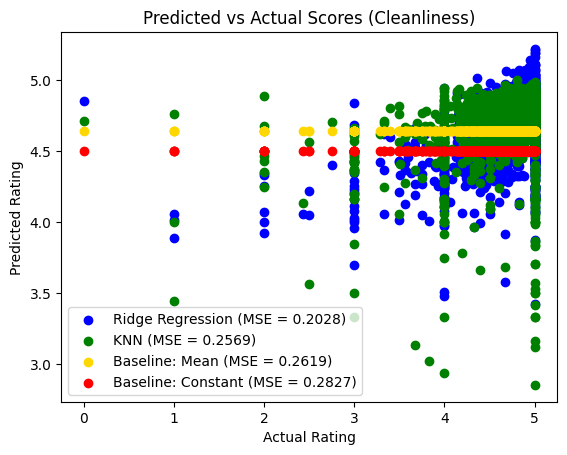

In [318]:
# COMPARE PERFORMANCE OF LINEAR AND KNN MODELS, ALONG WITH BASELINE PREDICTORS (Y_clean)

# Ridge Regression
optimal_c = 0.2
m_ridge = Ridge(alpha=1/optimal_c)
m_ridge.fit(new_X[train], Y_clean[train])

# KNN
m_knn = KNeighborsRegressor(n_neighbors=6, weights='uniform')
m_knn.fit(new_X[train], Y_clean[train])

# Baseline predictors (mean value and constant 4)
m_mean = DummyRegressor(strategy='mean')
m_mean.fit(new_X[train], Y_clean[train])
m_const = DummyRegressor(strategy='constant', constant=4.5)
m_const.fit(new_X[train], Y_clean[train])

# Get predictions for all models
# pred_linear = m_linear.predict(new_X[test])
pred_ridge = m_ridge.predict(new_X[test])
pred_knn = m_knn.predict(new_X[test])
pred_mean = m_mean.predict(new_X[test])
pred_const = m_const.predict(new_X[test])

# Calculate MSE for all models
from sklearn.metrics import mean_squared_error
# mse_linear = mean_squared_error(Y_clean[test], pred_linear)
mse_ridge = mean_squared_error(Y_clean[test], pred_ridge)
mse_knn = mean_squared_error(Y_clean[test], pred_knn)
mse_mean = mean_squared_error(Y_clean[test], pred_mean)
mse_const = mean_squared_error(Y_clean[test], pred_const)

# print(f'MSE for Linear Regression: {mse_linear}')
print(f'MSE for Ridge Regression: {mse_ridge}')
print(f'MSE for KNN: {mse_knn}')
print(f'MSE for Mean: {mse_mean}')
print(f'MSE for Constant: {mse_const}')

# Visualise performance of all models
# plt.scatter(Y_clean[test], pred_linear, color=colors[0], label='Linear Regression')
plt.scatter(Y_clean[test], pred_ridge, color=colors[0], label=f'Ridge Regression (MSE = {mse_ridge:.4f})')
plt.scatter(Y_clean[test], pred_knn, color=colors[1], label=f'KNN (MSE = {mse_knn:.4f})')
plt.scatter(Y_clean[test], pred_mean, color=colors[2], label=f'Baseline: Mean (MSE = {mse_mean:.4f})')
plt.scatter(Y_clean[test], pred_const, color=colors[3], label=f'Baseline: Constant (MSE = {mse_const:.4f})')

plt.title('Predicted vs Actual Scores (Cleanliness)')
plt.xlabel('Actual Rating')
# plt.xlim(2,5)
plt.ylabel('Predicted Rating')
# plt.ylim(2,5)
plt.legend()
plt.show()



MSE for Ridge Regression: 0.10467203502217406
MSE for KNN: 0.11767417534722223
MSE for Mean: 0.11508744191381116
MSE for Constant: 0.22885838815789472


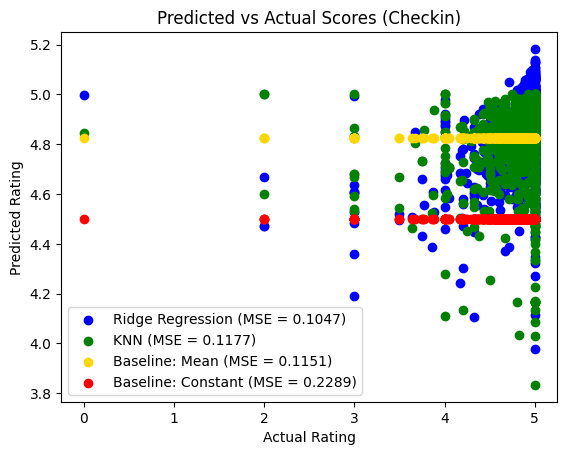

In [317]:
# COMPARE PERFORMANCE OF LINEAR AND KNN MODELS, ALONG WITH BASELINE PREDICTORS (Y_checkin)

# Ridge Regression
optimal_c = 0.2
m_ridge = Ridge(alpha=1/optimal_c)
m_ridge.fit(new_X[train], Y_checkin[train])

# KNN
m_knn = KNeighborsRegressor(n_neighbors=6, weights='uniform')
m_knn.fit(new_X[train], Y_checkin[train])

# Baseline predictors (mean value and constant 4)
m_mean = DummyRegressor(strategy='mean')
m_mean.fit(new_X[train], Y_checkin[train])
m_const = DummyRegressor(strategy='constant', constant=4.5)
m_const.fit(new_X[train], Y_checkin[train])

# Get predictions for all models
# pred_linear = m_linear.predict(new_X[test])
pred_ridge = m_ridge.predict(new_X[test])
pred_knn = m_knn.predict(new_X[test])
pred_mean = m_mean.predict(new_X[test])
pred_const = m_const.predict(new_X[test])

# Calculate MSE for all models
from sklearn.metrics import mean_squared_error
# mse_linear = mean_squared_error(Y_checkin[test], pred_linear)
mse_ridge = mean_squared_error(Y_checkin[test], pred_ridge)
mse_knn = mean_squared_error(Y_checkin[test], pred_knn)
mse_mean = mean_squared_error(Y_checkin[test], pred_mean)
mse_const = mean_squared_error(Y_checkin[test], pred_const)

# print(f'MSE for Linear Regression: {mse_linear}')
print(f'MSE for Ridge Regression: {mse_ridge}')
print(f'MSE for KNN: {mse_knn}')
print(f'MSE for Mean: {mse_mean}')
print(f'MSE for Constant: {mse_const}')

# Visualise performance of all models
# plt.scatter(Y_checkin[test], pred_linear, color=colors[0], label='Linear Regression')
plt.scatter(Y_checkin[test], pred_ridge, color=colors[0], label=f'Ridge Regression (MSE = {mse_ridge:.4f})')
plt.scatter(Y_checkin[test], pred_knn, color=colors[1], label=f'KNN (MSE = {mse_knn:.4f})')
plt.scatter(Y_checkin[test], pred_mean, color=colors[2], label=f'Baseline: Mean (MSE = {mse_mean:.4f})')
plt.scatter(Y_checkin[test], pred_const, color=colors[3], label=f'Baseline: Constant (MSE = {mse_const:.4f})')

plt.title('Predicted vs Actual Scores (Checkin)')
plt.xlabel('Actual Rating')
# plt.xlim(2,5)
plt.ylabel('Predicted Rating')
# plt.ylim(2,5)
plt.legend()
plt.show()



# Resampled Data

## Resampling

In [387]:
# Resample data to get more balanced target ratings
from sklearn.utils import resample

df_4_to_5stars = all_features[(Y_rating > 4) & (Y_rating <= 5)]
df_3_to_4stars = all_features[(Y_rating > 3) & (Y_rating <= 4)]
df_2_to_3stars = all_features[(Y_rating > 2) & (Y_rating <= 3)]
df_1_to_2stars = all_features[(Y_rating >= 1) & (Y_rating <= 2)]

# Print shape of each class
print('Original:\----')
print(f'4 to 5: {df_4_to_5stars.shape}')
print(f'3 to 4: {df_3_to_4stars.shape}')
print(f'2 to 3: {df_2_to_3stars.shape}')
print(f'1 to 2: {df_1_to_2stars.shape}')

# Resample each class to have 2000 samples
df_4_to_5stars_resampled = resample(df_4_to_5stars, replace=True, n_samples=4000, random_state=0)
df_3_to_4stars_resampled = resample(df_3_to_4stars, replace=True, n_samples=4000, random_state=0)
df_2_to_3stars_resampled = resample(df_2_to_3stars, replace=True, n_samples=4000, random_state=0)
df_1_to_2stars_resampled = resample(df_1_to_2stars, replace=True, n_samples=4000, random_state=0)

new_Y = targets.iloc[:,1:]

# Generate matching target ratings
Y_4_to_5stars_resampled = resample(new_Y[(Y_rating > 4) & (Y_rating <= 5)], replace=True, n_samples=4000, random_state=0)
Y_3_to_4stars_resampled = resample(new_Y[(Y_rating > 3) & (Y_rating <= 4)], replace=True, n_samples=4000, random_state=0)
Y_2_to_3stars_resampled = resample(new_Y[(Y_rating > 2) & (Y_rating <= 3)], replace=True, n_samples=4000, random_state=0)
Y_1_to_2stars_resampled = resample(new_Y[(Y_rating >= 1) & (Y_rating <= 2)], replace=True, n_samples=4000, random_state=0)

# Print new shape of each class
print('Resampled shapes:\----')
print(f'4 to 5: {df_4_to_5stars_resampled.shape}')
print(f'3 to 4: {df_3_to_4stars_resampled.shape}')
print(f'2 to 3: {df_2_to_3stars_resampled.shape}')
print(f'1 to 2: {df_1_to_2stars_resampled.shape}')

# Print new target ratings
# print('Target Ratings:\----')
# print(Y_4_to_5stars_upsampled)
# print(Y_3_to_4stars_upsampled)
# print(Y_2_to_3stars_upsampled)
# print(Y_1_to_2stars_upsampled)

# Combine resampled data
feats_resampled = pd.concat([df_4_to_5stars_resampled, df_3_to_4stars_resampled, df_2_to_3stars_resampled, df_1_to_2stars_resampled])
Y_resampled = pd.concat([Y_4_to_5stars_resampled, Y_3_to_4stars_resampled, Y_2_to_3stars_resampled, Y_1_to_2stars_resampled])

# Print shape of combined data
print('Combined shape:\----')
print(feats_resampled.shape)
print(Y_resampled.shape)

# Print head of combined data
# print('Combined head:\----')
# print(feats_resampled.head())
# print(Y_resampled.tail())

# Remove 'review_scores_' prefix from Y_resampled column names
Y_resampled.columns = Y_resampled.columns.str.replace('review_scores_', '')

# Print head of Y_resampled with new column names
print('New column names:\----')
print(feats_resampled.columns)
print(Y_resampled.columns)


Original:\----
4 to 5: (5609, 6)
3 to 4: (369, 6)
2 to 3: (71, 6)
1 to 2: (29, 6)
Resampled shapes:\----
4 to 5: (4000, 6)
3 to 4: (4000, 6)
2 to 3: (4000, 6)
1 to 2: (4000, 6)
Combined shape:\----
(16000, 6)
(16000, 7)
New column names:\----
Index(['id', 'host_is_superhost', 'host_total_listings_count', 'accommodates',
       'number_of_reviews', 'stems'],
      dtype='object')
Index(['rating', 'accuracy', 'cleanliness', 'checkin', 'communication',
       'location', 'value'],
      dtype='object')


## Re-extracting text features

min_df = 0.04
 - max_df = 0.2
 - max_df = 0.4
 - max_df = 0.6
 - max_df = 0.7
 - max_df = 0.8
min_df = 0.05
 - max_df = 0.2
 - max_df = 0.4
 - max_df = 0.6
 - max_df = 0.7
 - max_df = 0.8
min_df = 0.06
 - max_df = 0.2
 - max_df = 0.4
 - max_df = 0.6
 - max_df = 0.7
 - max_df = 0.8
min_df = 0.07
 - max_df = 0.2
 - max_df = 0.4
 - max_df = 0.6
 - max_df = 0.7
 - max_df = 0.8


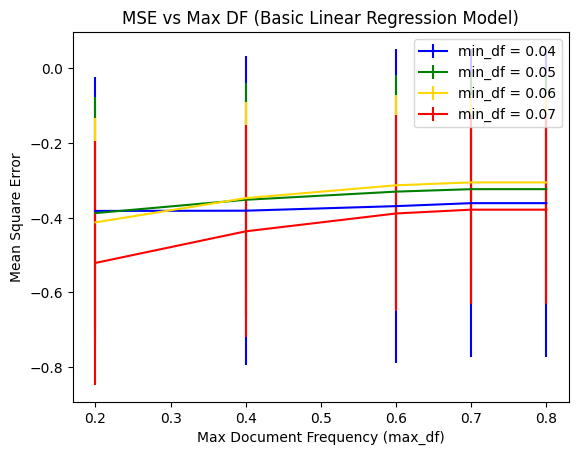

In [439]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer

colors = ['blue', 'green', 'gold', 'red', 'pink']

# df_min - exclude words which appear in too few documents
min_df_range = [0.04, 0.05, 0.06, 0.07]
# df_max - exclude words which appear in too many documents
max_df_range = [0.2, 0.4, 0.6, 0.7, 0.8]

for min_df_index, min_df in enumerate(min_df_range):
    print(f'min_df = {min_df}')

    mean_score=[]
    std_score=[]

    for max_df in max_df_range:
        print(f' - max_df = {max_df}')

        vectorizer = TfidfVectorizer(stop_words='english', min_df=min_df, max_df=max_df) # 79,179 features for 6,078 listings
        test_X = vectorizer.fit_transform(feats_resampled['stems'])

        model = LinearRegression()
        kf = KFold(n_splits=5)

        scores = cross_val_score(model, test_X, Y_resampled['rating'], cv=kf, scoring='neg_mean_squared_error')
        mean_score.append(np.array(scores).mean())
        std_score.append(np.array(scores).std())

    plt.errorbar(max_df_range,mean_score,yerr=std_score,color=colors[min_df_index],label=f'min_df = {min_df}')

plt.title('MSE vs Max DF (Basic Linear Regression Model)')
plt.xlabel('Max Document Frequency (max_df)')
plt.ylabel('Mean Square Error')
plt.legend()
plt.show()

min 0.06 -> max 0.7

In [393]:
# Create pipeline to use TF-IDF vectorizer on stems and passthrough other features
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer

# Set min_df and max_df to the values that gave the best results (lowest MSE)
RESAMPLED_MIN_DF = 0.06
RESAMPLED_MAX_DF = 0.7

RESAMPLED_CT = make_column_transformer(
    (StandardScaler(), ['host_total_listings_count', 'accommodates', 'number_of_reviews']),
    (TfidfVectorizer(stop_words='english', min_df=RESAMPLED_MIN_DF, max_df=RESAMPLED_MAX_DF), 'stems'),
    ('drop', 'id'),
    remainder='passthrough'
)

# pipeline = Pipeline([
#     ('transformer',  ct)
# ])

resampled_X = RESAMPLED_CT.fit_transform(feats_resampled)
print(resampled_X.shape)
print(RESAMPLED_CT.get_feature_names_out())

(16000, 481)
['standardscaler__host_total_listings_count'
 'standardscaler__accommodates' 'standardscaler__number_of_reviews'
 'tfidfvectorizer__10' 'tfidfvectorizer__100' 'tfidfvectorizer__15'
 'tfidfvectorizer__20' 'tfidfvectorizer__25' 'tfidfvectorizer__30'
 'tfidfvectorizer__abl' 'tfidfvectorizer__abov' 'tfidfvectorizer__absolut'
 'tfidfvectorizer__access' 'tfidfvectorizer__accommod'
 'tfidfvectorizer__accomod' 'tfidfvectorizer__accueil'
 'tfidfvectorizer__actual' 'tfidfvectorizer__advertis'
 'tfidfvectorizer__agréabl' 'tfidfvectorizer__air'
 'tfidfvectorizer__airbnb' 'tfidfvectorizer__airport'
 'tfidfvectorizer__al' 'tfidfvectorizer__allow' 'tfidfvectorizer__alway'
 'tfidfvectorizer__amaz' 'tfidfvectorizer__amen' 'tfidfvectorizer__ani'
 'tfidfvectorizer__anoth' 'tfidfvectorizer__answer'
 'tfidfvectorizer__anyon' 'tfidfvectorizer__anyth'
 'tfidfvectorizer__apart' 'tfidfvectorizer__apartamento'
 'tfidfvectorizer__appart' 'tfidfvectorizer__appreci'
 'tfidfvectorizer__area' 'tfidfvect

## Final Cross-Validation and Evaluation

### Rating


Coefs - Features of interest:
----------------
host_is_superhost: [-0.13013827]
host_total_listings_count: [-0.04037328]
accommodates: [0.05970787]
number_of_reviews: [-0.09383968]

Coefs - Top 5 increasing features:
----------------
tfidfvectorizer__zu: 1.3599011955171136
tfidfvectorizer__sehr: 1.4243475602905342
tfidfvectorizer__live: 1.4518287729854666
tfidfvectorizer__propr: 1.4548570005184736
tfidfvectorizer__non: 2.233089916723754

Coefs - Top 5 decreasing features:
----------------
tfidfvectorizer__se: -3.1481181157678937
tfidfvectorizer__left: -2.5190812481805103
tfidfvectorizer__smell: -2.3041962714544013
tfidfvectorizer__run: -2.0159934471639764
tfidfvectorizer__rent: -2.0148183445062253


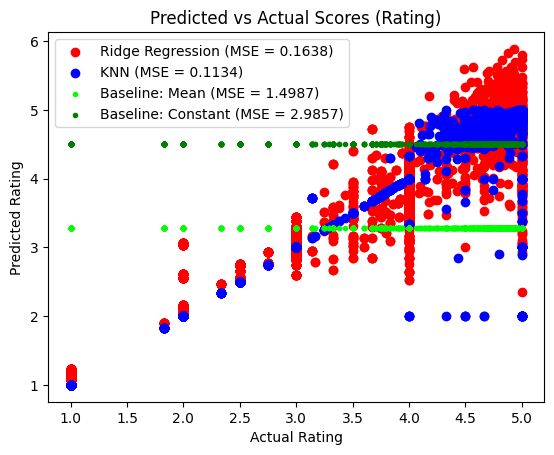

In [459]:
# COMPARE PERFORMANCE OF LINEAR AND KNN MODELS, ALONG WITH BASELINE PREDICTORS (rating)

# Create train test split

resampled_indices = np.arange(resampled_X.shape[0])

from sklearn.model_selection import train_test_split
r_train, r_test = train_test_split(resampled_indices, test_size=0.2, random_state=0)

# Ridge Regression
optimal_c = 0.8
m_ridge = Ridge(alpha=1/optimal_c)
m_ridge.fit(resampled_X[r_train], Y_resampled['rating'].iloc[r_train])

# KNN
m_knn = KNeighborsRegressor(n_neighbors=3, weights='uniform')
m_knn.fit(resampled_X[r_train], Y_resampled['rating'].iloc[r_train])

# Baseline predictors (mean value and constant 4)
m_mean = DummyRegressor(strategy='mean')
m_mean.fit(resampled_X[r_train], Y_resampled['rating'].iloc[r_train])
m_const = DummyRegressor(strategy='constant', constant=4.5)
m_const.fit(resampled_X[r_train], Y_resampled['rating'].iloc[r_train])

# Get predictions for all models
pred_ridge = m_ridge.predict(resampled_X[r_test])
pred_knn = m_knn.predict(resampled_X[r_test])
pred_mean = m_mean.predict(resampled_X[r_test])
pred_const = m_const.predict(resampled_X[r_test])

# Calculate MSE for all models
from sklearn.metrics import mean_squared_error
mse_ridge = mean_squared_error(Y_resampled['rating'].iloc[r_test], pred_ridge)
mse_knn = mean_squared_error(Y_resampled['rating'].iloc[r_test], pred_knn)
mse_mean = mean_squared_error(Y_resampled['rating'].iloc[r_test], pred_mean)
mse_const = mean_squared_error(Y_resampled['rating'].iloc[r_test], pred_const)

# print(f'MSE for Linear Regression: {mse_linear}')
# print(f'MSE for Ridge Regression: {mse_ridge}')
# print(f'MSE for KNN: {mse_knn}')
# print(f'MSE for Mean: {mse_mean}')
# print(f'MSE for Constant: {mse_const}')

# Print top 5 features for Ridge model
print_key_coefs(m_ridge.coef_, RESAMPLED_CT)

# Visualise performance of all models
plt.scatter(Y_resampled['rating'].iloc[r_test], pred_ridge, color=colors[0], label=f'Ridge Regression (MSE = {mse_ridge:.4f})', marker='o')
plt.scatter(Y_resampled['rating'].iloc[r_test], pred_knn, color=colors[1], label=f'KNN (MSE = {mse_knn:.4f})', marker='o')
plt.scatter(Y_resampled['rating'].iloc[r_test], pred_mean, color=colors[2], label=f'Baseline: Mean (MSE = {mse_mean:.4f})', marker='.')
plt.scatter(Y_resampled['rating'].iloc[r_test], pred_const, color=colors[3], label=f'Baseline: Constant (MSE = {mse_const:.4f})', marker='.')

plt.title('Predicted vs Actual Scores (Rating)')
plt.xlabel('Actual Rating')
# plt.xlim(2,5)
plt.ylabel('Predicted Rating')
# plt.ylim(2,5)
plt.legend()
plt.show()


Cross validation for new K - it's looking a little rough on resampled data

In [400]:
def gaussian_kernel20(distances):
    weights = np.exp(-20*(distances**2))
    return weights/np.sum(weights)
    

k = 2
k = 3
k = 4


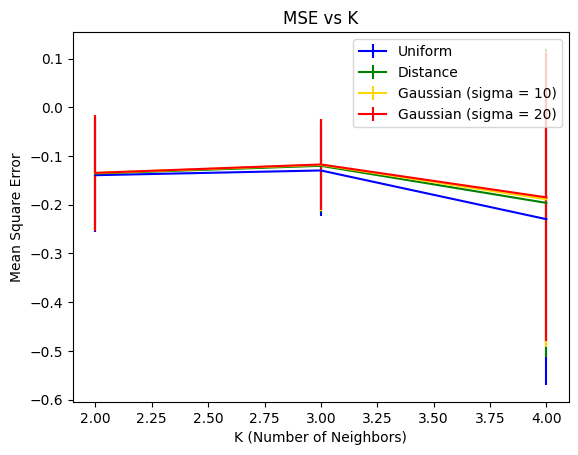

In [438]:
# CROSS-VALIDATION TO GET K FOR KNN MODEL

from sklearn.neighbors import KNeighborsRegressor

k_range = [2, 3, 4]

# Want a model with uniform weights, a model with distance weights, and a model for each of the three kernels
# And perform cross-validation on each of these models to get the best k

me_unif = []
me_dist = []
me_gaus10 = []
me_gaus20 = []
# me_gaus50 = []

se_unif = []
se_dist = []
se_gaus10 = []
se_gaus20 = []
# se_gaus50 = []

for k in k_range:
    print(f'k = {k}')
    
    # Model with uniform weights, a model with distance weights, and a model for each of the three kernels
    m_unif = KNeighborsRegressor(n_neighbors=k, weights='uniform')
    m_dist = KNeighborsRegressor(n_neighbors=k, weights='distance')
    m_gaus10 = KNeighborsRegressor(n_neighbors=k, weights=gaussian_kernel10)
    m_gaus20 = KNeighborsRegressor(n_neighbors=k, weights=gaussian_kernel20)
    # m_gaus50 = KNeighborsRegressor(n_neighbors=k, weights=gaussian_kernel50)

    kf = KFold(n_splits=5)

    errors_unif = cross_val_score(m_unif, resampled_X, Y_resampled['rating'], cv=kf, scoring='neg_mean_squared_error')
    errors_dist = cross_val_score(m_dist, resampled_X, Y_resampled['rating'], cv=kf, scoring='neg_mean_squared_error')
    errors_gaus10 = cross_val_score(m_gaus10, resampled_X, Y_resampled['rating'], cv=kf, scoring='neg_mean_squared_error')
    errors_gaus20 = cross_val_score(m_gaus20, resampled_X, Y_resampled['rating'], cv=kf, scoring='neg_mean_squared_error')
    # errors_gaus50 = cross_val_score(m_gaus50, resampled_X, Y_resampled['rating'], cv=kf, scoring='neg_mean_squared_error')

    me_unif.append(np.array(errors_unif).mean())
    me_dist.append(np.array(errors_dist).mean())
    me_gaus10.append(np.array(errors_gaus10).mean())
    me_gaus20.append(np.array(errors_gaus20).mean())
    # me_gaus50.append(np.array(errors_gaus50).mean())

    se_unif.append(np.array(errors_unif).std())
    se_dist.append(np.array(errors_dist).std())
    se_gaus10.append(np.array(errors_gaus10).std())
    se_gaus20.append(np.array(errors_gaus20).std())
    # se_gaus50.append(np.array(errors_gaus50).std())

plt.errorbar(k_range,me_unif,yerr=se_unif,color=colors[0],label=f'Uniform')
plt.errorbar(k_range,me_dist,yerr=se_dist,color=colors[1],label=f'Distance')
plt.errorbar(k_range,me_gaus10,yerr=se_gaus10,color=colors[2],label=f'Gaussian (sigma = 10)')
plt.errorbar(k_range,me_gaus20,yerr=se_gaus20,color=colors[3],label=f'Gaussian (sigma = 20)')
# plt.errorbar(k_range,me_gaus50,yerr=se_gaus50,color=colors[3],label=f'Gaussian (sigma = 50)')

plt.title('MSE vs K')
plt.xlabel('K (Number of Neighbors)')
plt.ylabel('Mean Square Error')
plt.legend()
plt.show()


k = 3 w/ Gaussian weighting, sigma=10

Cross-validation for C in regression models

C = 0.6
C = 0.8
C = 1.2


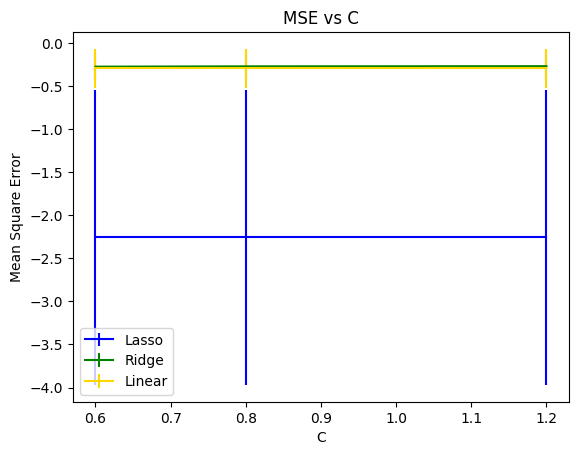

In [435]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline

colors = ['gold', 'red', 'blue', 'green', 'pink']
# c_range = [0.1, 1, 10, 100, 1000]
c_range = [0.6, 0.8, 1.2]
# c_range = [2000, 4000, 6000, 8000, 10000]

m_linear = LinearRegression()

me_lasso = []
me_ridge = []
me_linear = []

se_lasso = []
se_ridge = []
se_linear = []

for c in c_range:
    print(f'C = {c}')
    
    m_lasso = Lasso(alpha=1/c)
    m_ridge = Ridge(alpha=1/c)

    kf = KFold(n_splits=5)

    errors_lasso = cross_val_score(m_lasso, resampled_X, Y_resampled['rating'], cv=kf, scoring='neg_mean_squared_error')
    errors_ridge = cross_val_score(m_ridge, resampled_X, Y_resampled['rating'], cv=kf, scoring='neg_mean_squared_error')
    errors_linear = cross_val_score(model, resampled_X, Y_resampled['rating'], cv=kf, scoring='neg_mean_squared_error')

    me_lasso.append(np.array(errors_lasso).mean())
    me_ridge.append(np.array(errors_ridge).mean())
    me_linear.append(np.array(errors_linear).mean())

    se_lasso.append(np.array(errors_lasso).std())
    se_ridge.append(np.array(errors_ridge).std())
    se_linear.append(np.array(errors_linear).std())

plt.errorbar(c_range,me_lasso,yerr=se_lasso,color=colors[0],label=f'Lasso')
plt.errorbar(c_range,me_ridge,yerr=se_ridge,color=colors[1],label=f'Ridge')
plt.errorbar(c_range,me_linear,yerr=se_linear,color=colors[2],label=f'Linear')

plt.title('MSE vs C')
plt.xlabel('C')
plt.ylabel('Mean Square Error')
plt.legend()
plt.show()

C = 0.8 looking best

### Accuracy


Coefs - Features of interest:
----------------
host_is_superhost: [-0.13013827]
host_total_listings_count: [-0.04037328]
accommodates: [0.05970787]
number_of_reviews: [-0.09383968]

Coefs - Top 5 increasing features:
----------------
tfidfvectorizer__zu: 1.3599011955171136
tfidfvectorizer__sehr: 1.4243475602905342
tfidfvectorizer__live: 1.4518287729854666
tfidfvectorizer__propr: 1.4548570005184736
tfidfvectorizer__non: 2.233089916723754

Coefs - Top 5 decreasing features:
----------------
tfidfvectorizer__se: -3.1481181157678937
tfidfvectorizer__left: -2.5190812481805103
tfidfvectorizer__smell: -2.3041962714544013
tfidfvectorizer__run: -2.0159934471639764
tfidfvectorizer__rent: -2.0148183445062253


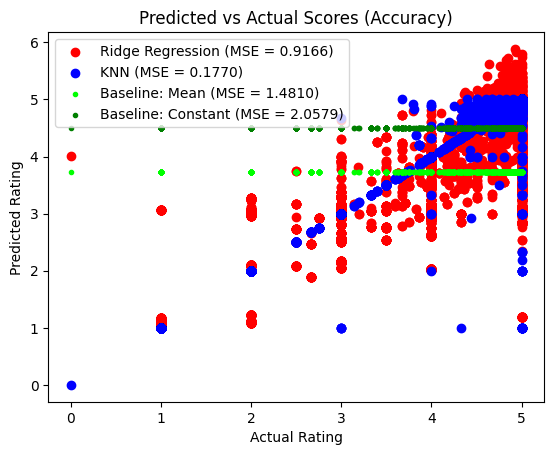

In [453]:
# COMPARE PERFORMANCE OF LINEAR AND KNN MODELS, ALONG WITH BASELINE PREDICTORS (accuracy)

# Columns in Y_resampled
# 'rating', 'accuracy', 'cleanliness', 'checkin', 'communication', 'location', 'value'

colors = ['red', 'blue', 'lime', 'green', 'pink']

# Ridge Regression
optimal_c = 0.8
m_ridge = Ridge(alpha=1/optimal_c)
m_ridge.fit(resampled_X[r_train], Y_resampled['rating'].iloc[r_train])

# KNN
m_knn = KNeighborsRegressor(n_neighbors=3, weights='uniform')
m_knn.fit(resampled_X[r_train], Y_resampled['accuracy'].iloc[r_train])

# Baseline predictors (mean value and constant 4)
m_mean = DummyRegressor(strategy='mean')
m_mean.fit(resampled_X[r_train], Y_resampled['accuracy'].iloc[r_train])
m_const = DummyRegressor(strategy='constant', constant=4.5)
m_const.fit(resampled_X[r_train], Y_resampled['accuracy'].iloc[r_train])

# Get predictions for all models
pred_ridge = m_ridge.predict(resampled_X[r_test])
pred_knn = m_knn.predict(resampled_X[r_test])
pred_mean = m_mean.predict(resampled_X[r_test])
pred_const = m_const.predict(resampled_X[r_test])

# Calculate MSE for all models
from sklearn.metrics import mean_squared_error
mse_ridge = mean_squared_error(Y_resampled['accuracy'].iloc[r_test], pred_ridge)
mse_knn = mean_squared_error(Y_resampled['accuracy'].iloc[r_test], pred_knn)
mse_mean = mean_squared_error(Y_resampled['accuracy'].iloc[r_test], pred_mean)
mse_const = mean_squared_error(Y_resampled['accuracy'].iloc[r_test], pred_const)

# print(f'MSE for Linear Regression: {mse_linear}')
# print(f'MSE for Ridge Regression: {mse_ridge}')
# print(f'MSE for KNN: {mse_knn}')
# print(f'MSE for Mean: {mse_mean}')
# print(f'MSE for Constant: {mse_const}')

# Print top 5 features for Ridge model
print_key_coefs(m_ridge.coef_, RESAMPLED_CT)

# Visualise performance of all models
plt.scatter(Y_resampled['accuracy'].iloc[r_test], pred_ridge, color=colors[0], label=f'Ridge Regression (MSE = {mse_ridge:.4f})', marker='o')
plt.scatter(Y_resampled['accuracy'].iloc[r_test], pred_knn, color=colors[1], label=f'KNN (MSE = {mse_knn:.4f})', marker='o')
plt.scatter(Y_resampled['accuracy'].iloc[r_test], pred_mean, color=colors[2], label=f'Baseline: Mean (MSE = {mse_mean:.4f})', marker='.')
plt.scatter(Y_resampled['accuracy'].iloc[r_test], pred_const, color=colors[3], label=f'Baseline: Constant (MSE = {mse_const:.4f})', marker='.')

plt.title('Predicted vs Actual Scores (Accuracy)')
plt.xlabel('Actual Rating')
# plt.xlim(2,5)
plt.ylabel('Predicted Rating')
# plt.ylim(2,5)
plt.legend()
plt.show()



### Cleanliness


Coefs - Features of interest:
----------------
host_is_superhost: [-0.22410231]
host_total_listings_count: [-0.05575035]
accommodates: [0.07870515]
number_of_reviews: [-0.10997193]

Coefs - Top 5 increasing features:
----------------
tfidfvectorizer__propr: 2.32058302431891
tfidfvectorizer__non: 2.388495927370818
tfidfvectorizer__todo: 2.4753947451967298
tfidfvectorizer__hand: 2.51553243450575
tfidfvectorizer__train: 2.909940198187832

Coefs - Top 5 decreasing features:
----------------
tfidfvectorizer__smell: -3.3352706222067776
tfidfvectorizer__rent: -2.9772756108526264
tfidfvectorizer__lack: -2.8960602826500423
tfidfvectorizer__cleanli: -2.800971357029308
tfidfvectorizer__left: -2.5112157809237505


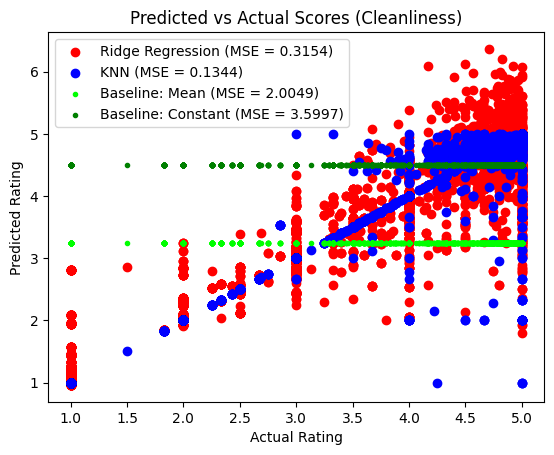

In [454]:
# COMPARE PERFORMANCE OF LINEAR AND KNN MODELS, ALONG WITH BASELINE PREDICTORS (cleanliness)

# Columns in Y_resampled
# 'rating', 'accuracy', 'cleanliness', 'checkin', 'communication', 'location', 'value'

# Ridge Regression
optimal_c = 0.8
m_ridge = Ridge(alpha=1/optimal_c)
m_ridge.fit(resampled_X[r_train], Y_resampled['cleanliness'].iloc[r_train])

# KNN
m_knn = KNeighborsRegressor(n_neighbors=3, weights='uniform')
m_knn.fit(resampled_X[r_train], Y_resampled['cleanliness'].iloc[r_train])

# Baseline predictors (mean value and constant 4)
m_mean = DummyRegressor(strategy='mean')
m_const = DummyRegressor(strategy='constant', constant=4.5)
m_mean.fit( resampled_X[r_train], Y_resampled['cleanliness'].iloc[r_train])
m_const.fit(resampled_X[r_train], Y_resampled['cleanliness'].iloc[r_train])

# Get predictions for all models
pred_ridge =    m_ridge.predict(resampled_X[r_test])
pred_knn =      m_knn.predict(resampled_X[r_test])
pred_mean =     m_mean.predict(resampled_X[r_test])
pred_const =    m_const.predict(resampled_X[r_test])

# Calculate MSE for all models
from sklearn.metrics import mean_squared_error
mse_ridge = mean_squared_error(Y_resampled['cleanliness'].iloc[r_test], pred_ridge)
mse_knn =   mean_squared_error(Y_resampled['cleanliness'].iloc[r_test], pred_knn)
mse_mean =  mean_squared_error(Y_resampled['cleanliness'].iloc[r_test], pred_mean)
mse_const = mean_squared_error(Y_resampled['cleanliness'].iloc[r_test], pred_const)

# print(f'MSE for Linear Regression: {mse_linear}')
# print(f'MSE for Ridge Regression: {mse_ridge}')
# print(f'MSE for KNN: {mse_knn}')
# print(f'MSE for Mean: {mse_mean}')
# print(f'MSE for Constant: {mse_const}')

# Print top 5 features for Ridge model
print_key_coefs(m_ridge.coef_, RESAMPLED_CT)

# Visualise performance of all models
plt.scatter(Y_resampled['cleanliness'].iloc[r_test], pred_ridge, color=colors[0], label=f'Ridge Regression (MSE = {mse_ridge:.4f})', marker='o')
plt.scatter(Y_resampled['cleanliness'].iloc[r_test], pred_knn, color=colors[1], label=f'KNN (MSE = {mse_knn:.4f})', marker='o')
plt.scatter(Y_resampled['cleanliness'].iloc[r_test], pred_mean, color=colors[2], label=f'Baseline: Mean (MSE = {mse_mean:.4f})', marker='.')
plt.scatter(Y_resampled['cleanliness'].iloc[r_test], pred_const, color=colors[3], label=f'Baseline: Constant (MSE = {mse_const:.4f})', marker='.')

plt.title('Predicted vs Actual Scores (Cleanliness)')
plt.xlabel('Actual Rating')
# plt.xlim(2,5)
plt.ylabel('Predicted Rating')
# plt.ylim(2,5)
plt.legend()
plt.show()



### Checkin


Coefs - Features of interest:
----------------
host_is_superhost: [-0.08955251]
host_total_listings_count: [-0.05962962]
accommodates: [-0.01921367]
number_of_reviews: [-0.04097839]

Coefs - Top 5 increasing features:
----------------
tfidfvectorizer__probabl: 2.1816700592093734
tfidfvectorizer__late: 2.253023643740813
tfidfvectorizer__pero: 2.283973360662518
tfidfvectorizer__non: 2.763248565795589
tfidfvectorizer__centro: 3.0044030422300927

Coefs - Top 5 decreasing features:
----------------
tfidfvectorizer__se: -4.430644928252289
tfidfvectorizer__avon: -3.459722782526325
tfidfvectorizer__offer: -3.3970636802319474
tfidfvectorizer__pa: -2.998883501493967
tfidfvectorizer__air: -2.863615379599601


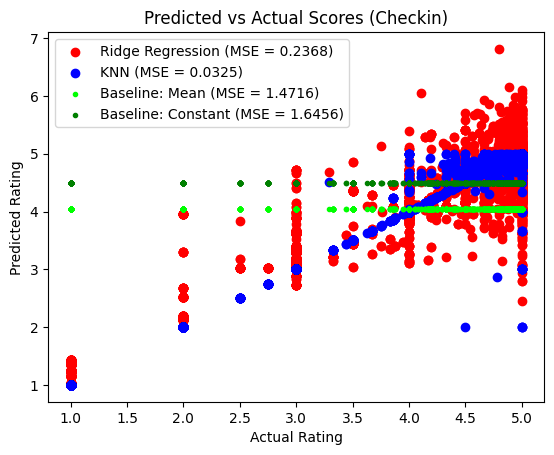

In [455]:
# COMPARE PERFORMANCE OF LINEAR AND KNN MODELS, ALONG WITH BASELINE PREDICTORS (checkin)

# Columns in Y_resampled
# 'rating', 'accuracy', 'cleanliness', 'checkin', 'communication', 'location', 'value'

# Ridge Regression
optimal_c = 0.8
m_ridge = Ridge(alpha=1/optimal_c)
m_ridge.fit(resampled_X[r_train], Y_resampled['checkin'].iloc[r_train])

# KNN
m_knn = KNeighborsRegressor(n_neighbors=3, weights='uniform')
m_knn.fit(resampled_X[r_train], Y_resampled['checkin'].iloc[r_train])

# Baseline predictors (mean value and constant 4)
m_mean = DummyRegressor(strategy='mean')
m_const = DummyRegressor(strategy='constant', constant=4.5)
m_mean.fit( resampled_X[r_train], Y_resampled['checkin'].iloc[r_train])
m_const.fit(resampled_X[r_train], Y_resampled['checkin'].iloc[r_train])

# Get predictions for all models
pred_ridge =    m_ridge.predict(resampled_X[r_test])
pred_knn =      m_knn.predict(resampled_X[r_test])
pred_mean =     m_mean.predict(resampled_X[r_test])
pred_const =    m_const.predict(resampled_X[r_test])

# Calculate MSE for all models
from sklearn.metrics import mean_squared_error
mse_ridge = mean_squared_error(Y_resampled['checkin'].iloc[r_test], pred_ridge)
mse_knn =   mean_squared_error(Y_resampled['checkin'].iloc[r_test], pred_knn)
mse_mean =  mean_squared_error(Y_resampled['checkin'].iloc[r_test], pred_mean)
mse_const = mean_squared_error(Y_resampled['checkin'].iloc[r_test], pred_const)

# print(f'MSE for Linear Regression: {mse_linear}')
# print(f'MSE for Ridge Regression: {mse_ridge}')
# print(f'MSE for KNN: {mse_knn}')
# print(f'MSE for Mean: {mse_mean}')
# print(f'MSE for Constant: {mse_const}')

# Print top 5 features for Ridge model
print_key_coefs(m_ridge.coef_, RESAMPLED_CT)

# Visualise performance of all models
plt.scatter(Y_resampled['checkin'].iloc[r_test], pred_ridge, color=colors[0], label=f'Ridge Regression (MSE = {mse_ridge:.4f})', marker='o')
plt.scatter(Y_resampled['checkin'].iloc[r_test], pred_knn, color=colors[1], label=f'KNN (MSE = {mse_knn:.4f})', marker='o')
plt.scatter(Y_resampled['checkin'].iloc[r_test], pred_mean, color=colors[2], label=f'Baseline: Mean (MSE = {mse_mean:.4f})', marker='.')
plt.scatter(Y_resampled['checkin'].iloc[r_test], pred_const, color=colors[3], label=f'Baseline: Constant (MSE = {mse_const:.4f})', marker='.')

plt.title('Predicted vs Actual Scores (Checkin)')
plt.xlabel('Actual Rating')
# plt.xlim(2,5)
plt.ylabel('Predicted Rating')
# plt.ylim(2,5)
plt.legend()
plt.show()



### Communication


Coefs - Features of interest:
----------------
host_is_superhost: [-0.09966983]
host_total_listings_count: [-0.16803087]
accommodates: [0.05529075]
number_of_reviews: [-0.03568794]

Coefs - Top 5 increasing features:
----------------
tfidfvectorizer__gener: 1.849455516474438
tfidfvectorizer__bit: 1.9064665425611325
tfidfvectorizer__non: 2.0230859909812486
tfidfvectorizer__pero: 2.110079234034034
tfidfvectorizer__everywher: 2.279587629497673

Coefs - Top 5 decreasing features:
----------------
tfidfvectorizer__se: -4.847975466088759
tfidfvectorizer__del: -2.9178755791006616
tfidfvectorizer__di: -2.7297313870579836
tfidfvectorizer__air: -2.713162043991032
tfidfvectorizer__casa: -2.621682689820814


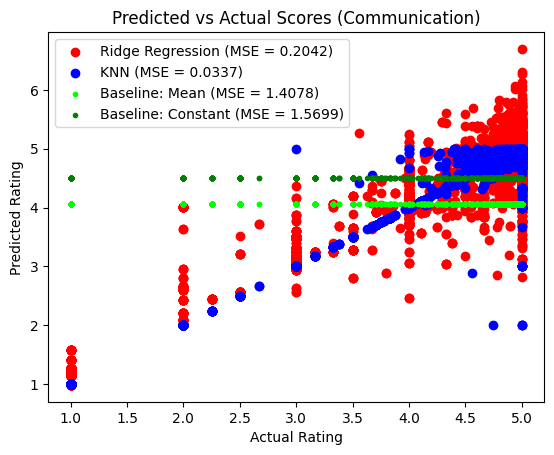

In [456]:
# COMPARE PERFORMANCE OF LINEAR AND KNN MODELS, ALONG WITH BASELINE PREDICTORS (communication)

# Columns in Y_resampled
# 'rating', 'accuracy', 'cleanliness', 'checkin', 'communication', 'location', 'value'

# Ridge Regression
optimal_c = 0.8
m_ridge = Ridge(alpha=1/optimal_c)
m_ridge.fit(resampled_X[r_train], Y_resampled['communication'].iloc[r_train])

# KNN
m_knn = KNeighborsRegressor(n_neighbors=3, weights='uniform')
m_knn.fit(resampled_X[r_train], Y_resampled['communication'].iloc[r_train])

# Baseline predictors (mean value and constant 4)
m_mean = DummyRegressor(strategy='mean')
m_const = DummyRegressor(strategy='constant', constant=4.5)
m_mean.fit( resampled_X[r_train], Y_resampled['communication'].iloc[r_train])
m_const.fit(resampled_X[r_train], Y_resampled['communication'].iloc[r_train])

# Get predictions for all models
pred_ridge =    m_ridge.predict(resampled_X[r_test])
pred_knn =      m_knn.predict(resampled_X[r_test])
pred_mean =     m_mean.predict(resampled_X[r_test])
pred_const =    m_const.predict(resampled_X[r_test])

# Calculate MSE for all models
from sklearn.metrics import mean_squared_error
mse_ridge = mean_squared_error(Y_resampled['communication'].iloc[r_test], pred_ridge)
mse_knn =   mean_squared_error(Y_resampled['communication'].iloc[r_test], pred_knn)
mse_mean =  mean_squared_error(Y_resampled['communication'].iloc[r_test], pred_mean)
mse_const = mean_squared_error(Y_resampled['communication'].iloc[r_test], pred_const)

# print(f'MSE for Linear Regression: {mse_linear}')
# print(f'MSE for Ridge Regression: {mse_ridge}')
# print(f'MSE for KNN: {mse_knn}')
# print(f'MSE for Mean: {mse_mean}')
# print(f'MSE for Constant: {mse_const}')

# Print top 5 features for Ridge model
print_key_coefs(m_ridge.coef_, RESAMPLED_CT)

# Visualise performance of all models
plt.scatter(Y_resampled['communication'].iloc[r_test], pred_ridge, color=colors[0], label=f'Ridge Regression (MSE = {mse_ridge:.4f})', marker='o')
plt.scatter(Y_resampled['communication'].iloc[r_test], pred_knn, color=colors[1], label=f'KNN (MSE = {mse_knn:.4f})', marker='o')
plt.scatter(Y_resampled['communication'].iloc[r_test], pred_mean, color=colors[2], label=f'Baseline: Mean (MSE = {mse_mean:.4f})', marker='.')
plt.scatter(Y_resampled['communication'].iloc[r_test], pred_const, color=colors[3], label=f'Baseline: Constant (MSE = {mse_const:.4f})', marker='.')

plt.title('Predicted vs Actual Scores (Communication)')
plt.xlabel('Actual Rating')
# plt.xlim(2,5)
plt.ylabel('Predicted Rating')
# plt.ylim(2,5)
plt.legend()
plt.show()



### Location


Coefs - Features of interest:
----------------
host_is_superhost: [-0.0758964]
host_total_listings_count: [-0.02133909]
accommodates: [0.03825818]
number_of_reviews: [-0.05310022]

Coefs - Top 5 increasing features:
----------------
tfidfvectorizer__wir: 1.8123000845916446
tfidfvectorizer__unfortun: 1.827882964081051
tfidfvectorizer__review: 1.8753013781713852
tfidfvectorizer__wall: 2.082606750827063
tfidfvectorizer__pero: 2.242495062311982

Coefs - Top 5 decreasing features:
----------------
tfidfvectorizer__se: -4.739387833676177
tfidfvectorizer__avon: -3.165798393894345
tfidfvectorizer__build: -2.8533423747756728
tfidfvectorizer__far: -2.4659226181468425
tfidfvectorizer__got: -2.422180627845608


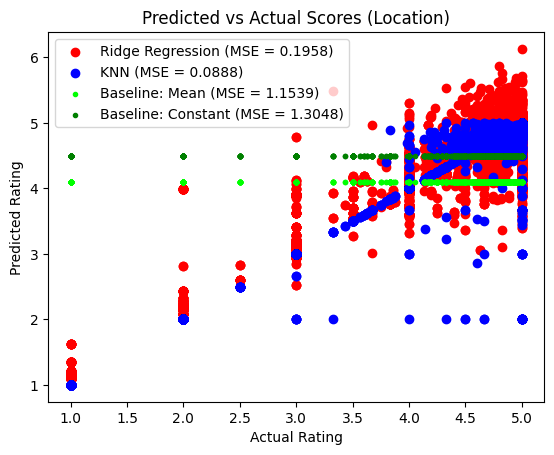

In [457]:
# COMPARE PERFORMANCE OF LINEAR AND KNN MODELS, ALONG WITH BASELINE PREDICTORS (location)

# Columns in Y_resampled
# 'rating', 'accuracy', 'cleanliness', 'checkin', 'communication', 'location', 'value'

# Ridge Regression
optimal_c = 0.8
m_ridge = Ridge(alpha=1/optimal_c)
m_ridge.fit(resampled_X[r_train], Y_resampled['location'].iloc[r_train])

# KNN
m_knn = KNeighborsRegressor(n_neighbors=3, weights='uniform')
m_knn.fit(resampled_X[r_train], Y_resampled['location'].iloc[r_train])

# Baseline predictors (mean value and constant 4)
m_mean = DummyRegressor(strategy='mean')
m_const = DummyRegressor(strategy='constant', constant=4.5)
m_mean.fit( resampled_X[r_train], Y_resampled['location'].iloc[r_train])
m_const.fit(resampled_X[r_train], Y_resampled['location'].iloc[r_train])

# Get predictions for all models
pred_ridge =    m_ridge.predict(resampled_X[r_test])
pred_knn =      m_knn.predict(resampled_X[r_test])
pred_mean =     m_mean.predict(resampled_X[r_test])
pred_const =    m_const.predict(resampled_X[r_test])

# Calculate MSE for all models
from sklearn.metrics import mean_squared_error
mse_ridge = mean_squared_error(Y_resampled['location'].iloc[r_test], pred_ridge)
mse_knn =   mean_squared_error(Y_resampled['location'].iloc[r_test], pred_knn)
mse_mean =  mean_squared_error(Y_resampled['location'].iloc[r_test], pred_mean)
mse_const = mean_squared_error(Y_resampled['location'].iloc[r_test], pred_const)

# print(f'MSE for Linear Regression: {mse_linear}')
# print(f'MSE for Ridge Regression: {mse_ridge}')
# print(f'MSE for KNN: {mse_knn}')
# print(f'MSE for Mean: {mse_mean}')
# print(f'MSE for Constant: {mse_const}')

# Print top 5 features for Ridge model
print_key_coefs(m_ridge.coef_, RESAMPLED_CT)

# Visualise performance of all models
plt.scatter(Y_resampled['location'].iloc[r_test], pred_ridge, color=colors[0], label=f'Ridge Regression (MSE = {mse_ridge:.4f})', marker='o')
plt.scatter(Y_resampled['location'].iloc[r_test], pred_knn, color=colors[1], label=f'KNN (MSE = {mse_knn:.4f})', marker='o')
plt.scatter(Y_resampled['location'].iloc[r_test], pred_mean, color=colors[2], label=f'Baseline: Mean (MSE = {mse_mean:.4f})', marker='.')
plt.scatter(Y_resampled['location'].iloc[r_test], pred_const, color=colors[3], label=f'Baseline: Constant (MSE = {mse_const:.4f})', marker='.')

plt.title('Predicted vs Actual Scores (Location)')
plt.xlabel('Actual Rating')
# plt.xlim(2,5)
plt.ylabel('Predicted Rating')
# plt.ylim(2,5)
plt.legend()
plt.show()



### Value


Coefs - Features of interest:
----------------
host_is_superhost: [-0.20210126]
host_total_listings_count: [0.03941257]
accommodates: [0.01241534]
number_of_reviews: [-0.09416694]

Coefs - Top 5 increasing features:
----------------
tfidfvectorizer__pero: 1.9138180106006977
tfidfvectorizer__live: 2.0126596955146603
tfidfvectorizer__review: 2.0183257685658678
tfidfvectorizer__free: 2.099651394662153
tfidfvectorizer__pay: 2.537728774171469

Coefs - Top 5 decreasing features:
----------------
tfidfvectorizer__se: -2.8669491550695727
tfidfvectorizer__por: -2.5445718558799792
tfidfvectorizer__bad: -2.377283323156598
tfidfvectorizer__tri: -2.265882641620874
tfidfvectorizer__run: -2.2163830722778846


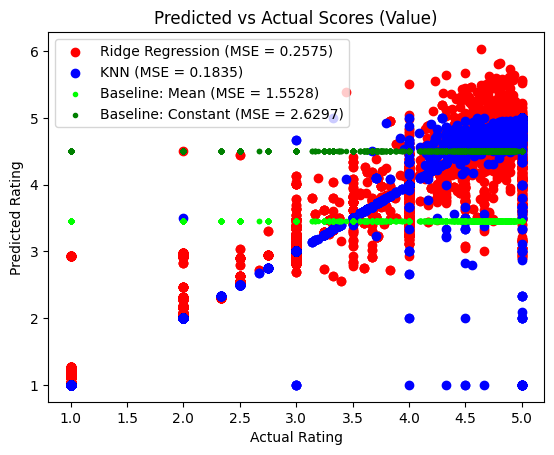

In [458]:
# COMPARE PERFORMANCE OF LINEAR AND KNN MODELS, ALONG WITH BASELINE PREDICTORS (value)

# Columns in Y_resampled
# 'rating', 'accuracy', 'cleanliness', 'checkin', 'communication', 'location', 'value'

# Ridge Regression
optimal_c = 0.8
m_ridge = Ridge(alpha=1/optimal_c)
m_ridge.fit(resampled_X[r_train], Y_resampled['value'].iloc[r_train])

# KNN
m_knn = KNeighborsRegressor(n_neighbors=3, weights='uniform')
m_knn.fit(resampled_X[r_train], Y_resampled['value'].iloc[r_train])

# Baseline predictors (mean value and constant 4)
m_mean = DummyRegressor(strategy='mean')
m_const = DummyRegressor(strategy='constant', constant=4.5)
m_mean.fit( resampled_X[r_train], Y_resampled['value'].iloc[r_train])
m_const.fit(resampled_X[r_train], Y_resampled['value'].iloc[r_train])

# Get predictions for all models
pred_ridge =    m_ridge.predict(resampled_X[r_test])
pred_knn =      m_knn.predict(resampled_X[r_test])
pred_mean =     m_mean.predict(resampled_X[r_test])
pred_const =    m_const.predict(resampled_X[r_test])

# Calculate MSE for all models
from sklearn.metrics import mean_squared_error
mse_ridge = mean_squared_error(Y_resampled['value'].iloc[r_test], pred_ridge)
mse_knn =   mean_squared_error(Y_resampled['value'].iloc[r_test], pred_knn)
mse_mean =  mean_squared_error(Y_resampled['value'].iloc[r_test], pred_mean)
mse_const = mean_squared_error(Y_resampled['value'].iloc[r_test], pred_const)

# print(f'MSE for Linear Regression: {mse_linear}')
# print(f'MSE for Ridge Regression: {mse_ridge}')
# print(f'MSE for KNN: {mse_knn}')
# print(f'MSE for Mean: {mse_mean}')
# print(f'MSE for Constant: {mse_const}')

# Print top 5 features for Ridge model
print_key_coefs(m_ridge.coef_, RESAMPLED_CT)

# Visualise performance of all models
plt.scatter(Y_resampled['value'].iloc[r_test], pred_ridge, color=colors[0], label=f'Ridge Regression (MSE = {mse_ridge:.4f})', marker='o')
plt.scatter(Y_resampled['value'].iloc[r_test], pred_knn, color=colors[1], label=f'KNN (MSE = {mse_knn:.4f})', marker='o')
plt.scatter(Y_resampled['value'].iloc[r_test], pred_mean, color=colors[2], label=f'Baseline: Mean (MSE = {mse_mean:.4f})', marker='.')
plt.scatter(Y_resampled['value'].iloc[r_test], pred_const, color=colors[3], label=f'Baseline: Constant (MSE = {mse_const:.4f})', marker='.')

plt.title('Predicted vs Actual Scores (Value)')
plt.xlabel('Actual Rating')
# plt.xlim(2,5)
plt.ylabel('Predicted Rating')
# plt.ylim(2,5)
plt.legend()
plt.show()

